In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [2]:
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', '{:.2f}'.format)

Import Dataset

In [3]:
df = pd.read_csv("/content/used_cars_data.csv")
df.sample(5)

,S.No.,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
2419,2419,Honda Amaze S i-Vtech,Delhi,2014,69876,Petrol,Manual,First,18.0 kmpl,1198 CC,86.7 bhp,5.00,NaN,3.90
5092,5092,Maruti Swift VXI BSIV,Hyderabad,2014,61922,Petrol,Manual,First,20.4 kmpl,1197 CC,81.80 bhp,5.00,NaN,5.30
2539,2539,Honda City i DTEC VX Option,Pune,2014,71000,Diesel,Manual,First,25.1 kmpl,1498 CC,98.6 bhp,5.00,NaN,7.45
2221,2221,Volkswagen Polo Petrol Comfortline 1.2L,Jaipur,2011,46000,Petrol,Manual,First,16.47 kmpl,1198 CC,73.9 bhp,5.00,NaN,3.05
4811,4811,Mahindra Thar CRDe,Coimbatore,2017,28599,Diesel,Manual,First,16.55 kmpl,2498 CC,105 bhp,6.00,11.71 Lakh,9.66


Data Preparation

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S.No.              7253 non-null   int64  
 1   Name               7253 non-null   object 
 2   Location           7253 non-null   object 
 3   Year               7253 non-null   int64  
 4   Kilometers_Driven  7253 non-null   int64  
 5   Fuel_Type          7253 non-null   object 
 6   Transmission       7253 non-null   object 
 7   Owner_Type         7253 non-null   object 
 8   Mileage            7251 non-null   object 
 9   Engine             7207 non-null   object 
 10  Power              7207 non-null   object 
 11  Seats              7200 non-null   float64
 12  New_Price          1006 non-null   object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 793.4+ KB


In [5]:
# Convert Mileage into numerical form
df["Mileage"] = df["Mileage"].str.replace(r"([kmpl/g])", "").astype("float")

In [6]:
# Convert Power Column in numerical form
df["Power"] = df["Power"].replace("null bhp", 0)
df["Power"] = df["Power"].str.replace(r"([ bhp])", "").astype("float")

mean_power = df[df["Power"] != 0]
df["Power"] = df["Power"].replace(0, mean_power["Power"].mean())
df["Power"].fillna(mean_power["Power"].mean(), inplace = True)

In [7]:
# Convert New Price Column in numerical form
df["New_Price"] = df["New_Price"].str.replace(r"([LakhCr])", "").astype("float")
df["New_Price"].fillna(0, inplace = True)

In [8]:
# Fill missing values with Average
df["Seats"].fillna(df["Seats"].mean(), inplace = True)

In [9]:
# Convert Engine Column in numerical form
df["Engine"] = df["Engine"].str.replace(r"([CC])", "").astype("float")
df["Engine"].fillna(df["Engine"].mean(), inplace = True)

In [10]:
# Drop New Price Column as it contains almost 90% missing values
df = df.drop(columns = ["New_Price"])

In [11]:
# Drop null values of Price Column
df = df[df['Price'].notna()]

In [12]:
# Rename Columns
df = df.rename(columns = {"Mileage": "Mileage kmpl/kg",
                          "Engine": "Engine CC",
                          "Power": "Power bph"})

Cleaned Data

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S.No.              6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage kmpl/kg    6017 non-null   float64
 9   Engine CC          6019 non-null   float64
 10  Power bph          6019 non-null   float64
 11  Seats              6019 non-null   float64
 12  Price              6019 non-null   float64
dtypes: float64(5), int64(3), object(5)
memory usage: 658.3+ KB


In [14]:
df.describe()

,S.No.,Year,Kilometers_Driven,Mileage kmpl/kg,Engine CC,Power bph,Seats,Price
count,6019.00,6019.00,6019.00,6017.00,6019.00,6019.00,6019.00,6019.00
mean,3009.00,2013.36,58738.38,18.13,1621.25,113.24,5.28,9.48
std,1737.68,3.27,91268.84,4.58,599.55,53.23,0.81,11.19
min,0.00,1998.00,171.00,0.00,72.00,34.20,0.00,0.44
25%,1504.50,2011.00,34000.00,15.17,1198.00,78.00,5.00,3.50
50%,3009.00,2014.00,53000.00,18.15,1493.00,98.60,5.00,5.64
75%,4513.50,2016.00,73000.00,21.10,1969.00,138.03,5.00,9.95
max,6018.00,2019.00,6500000.00,33.54,5998.00,560.00,10.00,160.00


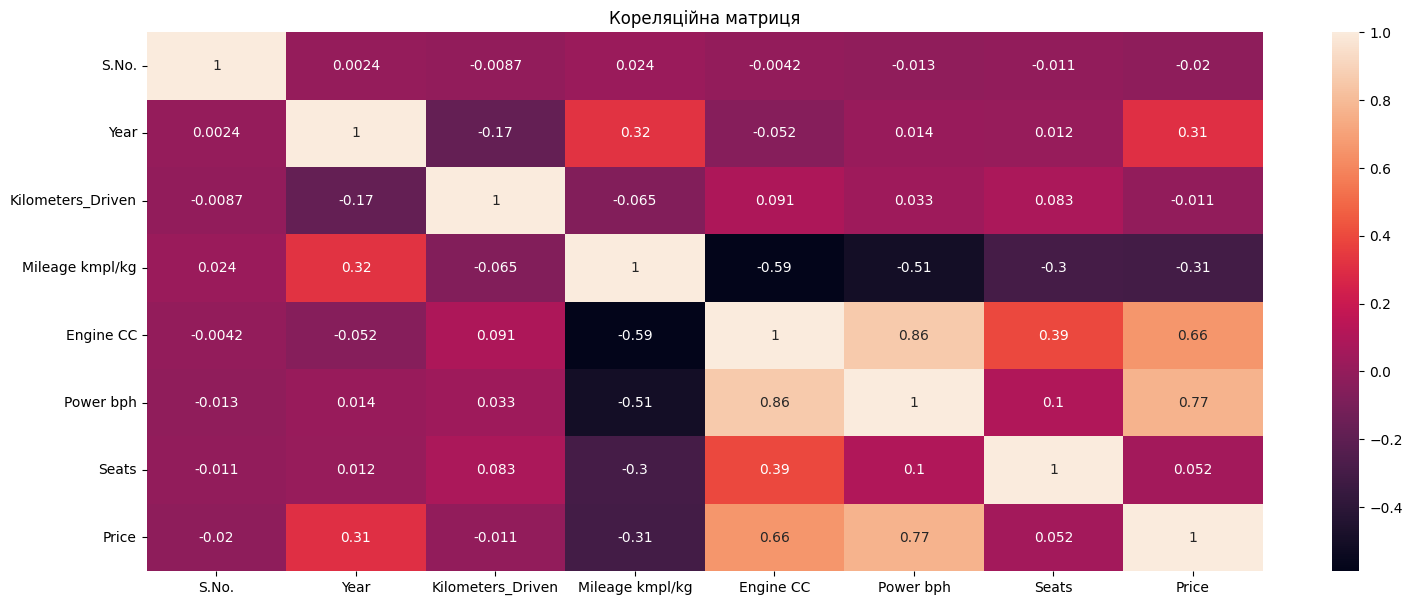

In [15]:
plt.figure(figsize = (18, 7))
correlation = df.corr()
sns.heatmap(correlation, annot = True)
plt.title("Кореляційна матриця")
plt.show()
plt.close()
plt.show()

Exploratory Data Analysis

Top 10 cars by frequency

In [16]:
cars = df["Name"].value_counts().to_frame().reset_index().head(10)
cars.columns = ["Cars", "Frequency"]
cars

,Cars,Frequency
0,Mahindra XUV500 W8 2WD,49
1,Maruti Swift VDI,45
2,Honda City 1.5 S MT,34
3,Maruti Swift Dzire VDI,34
4,Maruti Swift VDI BSIV,31
5,Maruti Ritz VDi,30
6,Hyundai i10 Sportz,30
7,Toyota Fortuner 3.0 Diesel,29
8,Honda Amaze S i-Dtech,27
9,Hyundai Grand i10 Sportz,27


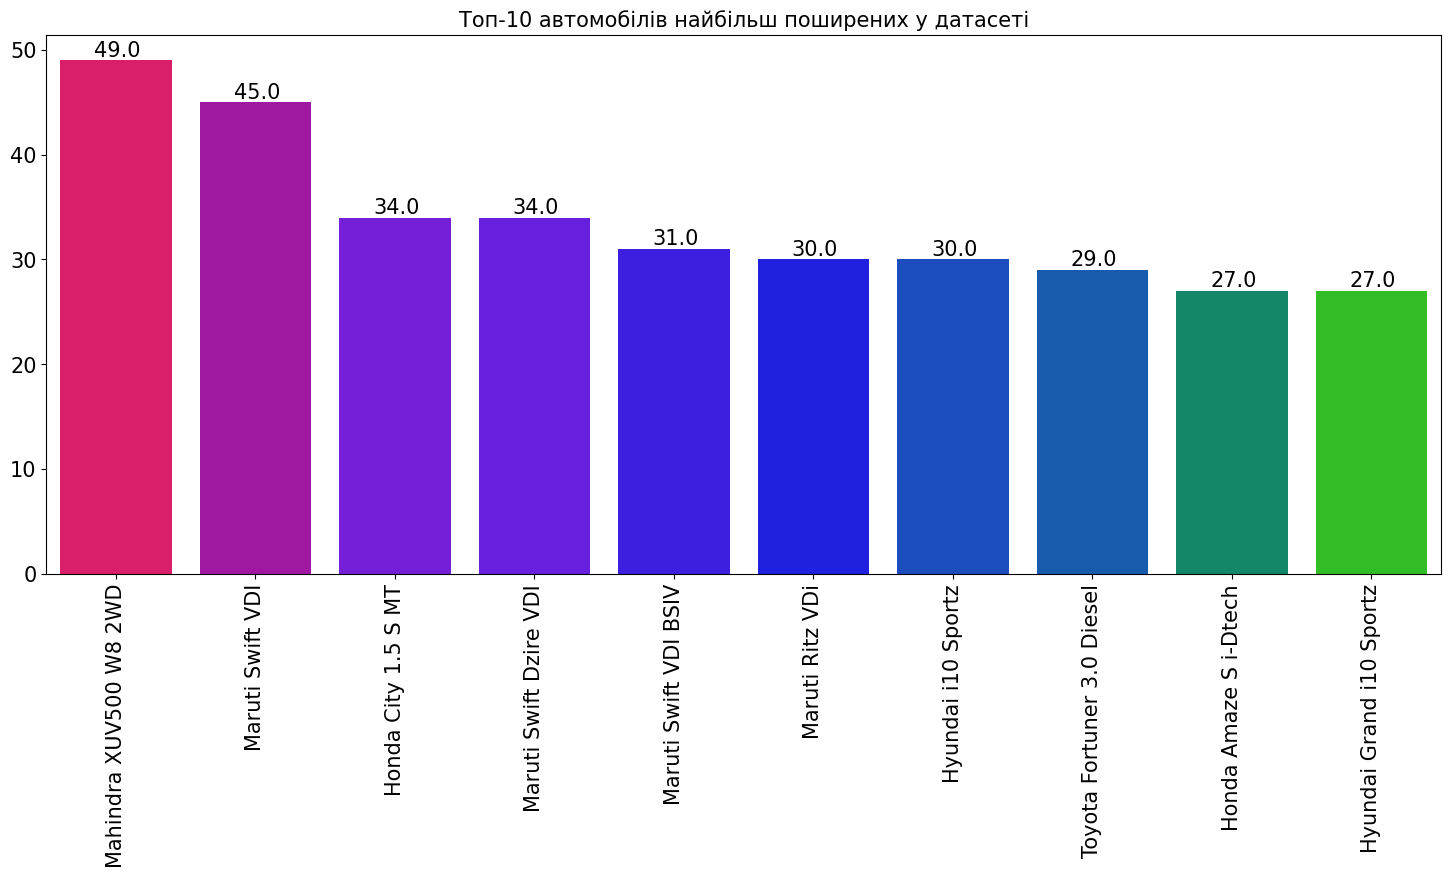

In [ ]:
plt.figure(figsize = (18, 7))
graph = sns.barplot(x = "Cars", y = "Frequency", data = cars, palette = "prism")
for p in graph.patches:
  graph.annotate('{:.01f}'.format(p.get_height()),
                 (p.get_x()+0.41, p.get_height()),
                 ha='center', va='bottom', color='black', size = 15)
plt.title("Топ-10 автомобілів найбільш поширених у датасеті", size = 15)
plt.xticks(size = 15, rotation = 90)
plt.yticks(size = 15)
plt.xlabel(None)
plt.ylabel(None)
plt.show()

Locations having number of cars selling

In [ ]:
city = df["Location"].value_counts().reset_index()
city.columns = ["City", "Cars"]
city

,City,Cars
0,Mumbai,790
1,Hyderabad,742
2,Kochi,651
3,Coimbatore,636
4,Pune,622
5,Delhi,554
6,Kolkata,535
7,Chennai,494
8,Jaipur,413
9,Bangalore,358


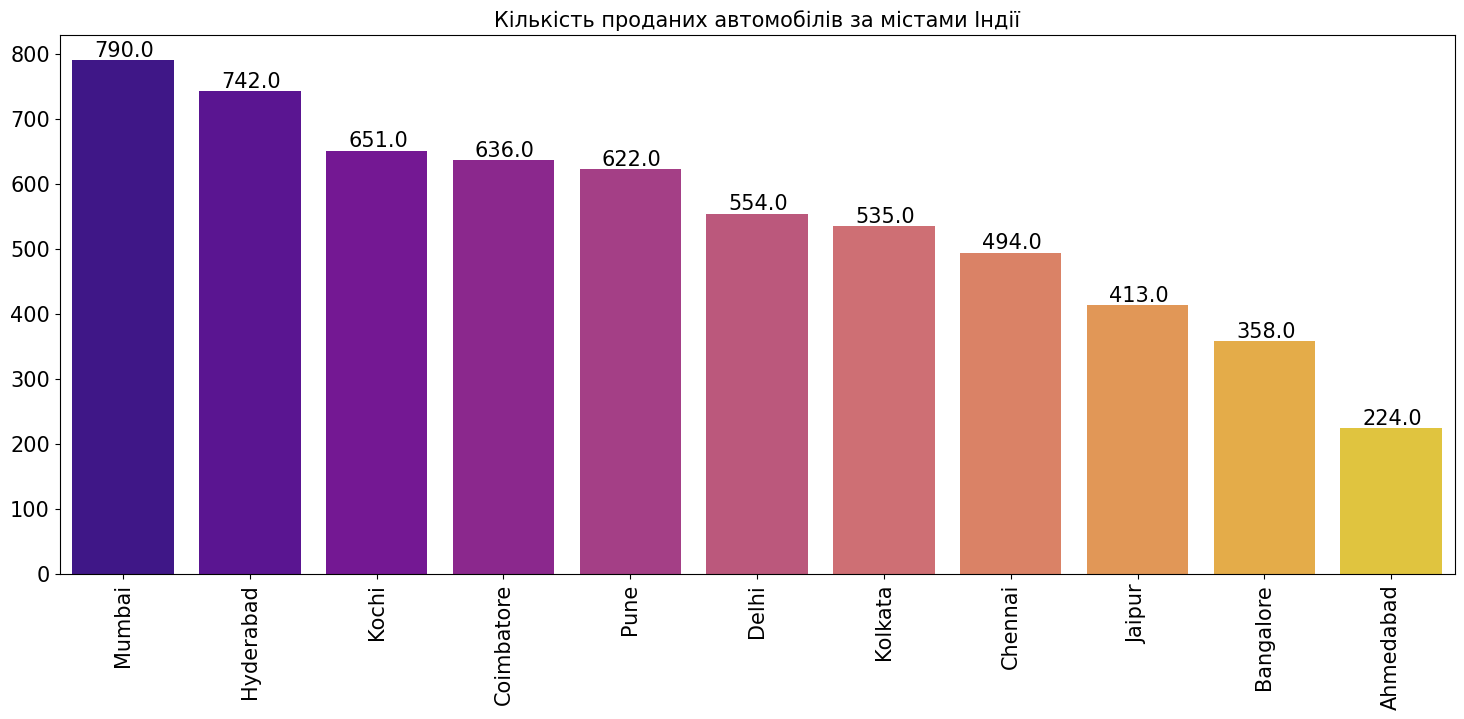

In [ ]:
plt.figure(figsize = (18, 7))
graph = sns.barplot(x="City", y = "Cars", data = city, palette = "plasma")
for p in graph.patches:
  graph.annotate('{:.01f}'.format(p.get_height()),
                 (p.get_x()+0.41, p.get_height()),
                 ha='center', va='bottom', color='black', size = 15)
plt.title("Кількість проданих автомобілів за містами Індії", size = 15)
plt.xticks(size = 15, rotation = 90)
plt.yticks(size = 15)
plt.xlabel(None)
plt.ylabel(None)
plt.show()

Years having number of cars selling

In [ ]:
years = df["Year"].value_counts().to_frame().reset_index()
years.columns = ["Years", "Cars"]
years

,Years,Cars
0,2014,797
1,2015,744
2,2016,741
3,2013,649
4,2017,587
5,2012,580
6,2011,466
7,2010,342
8,2018,298
9,2009,198


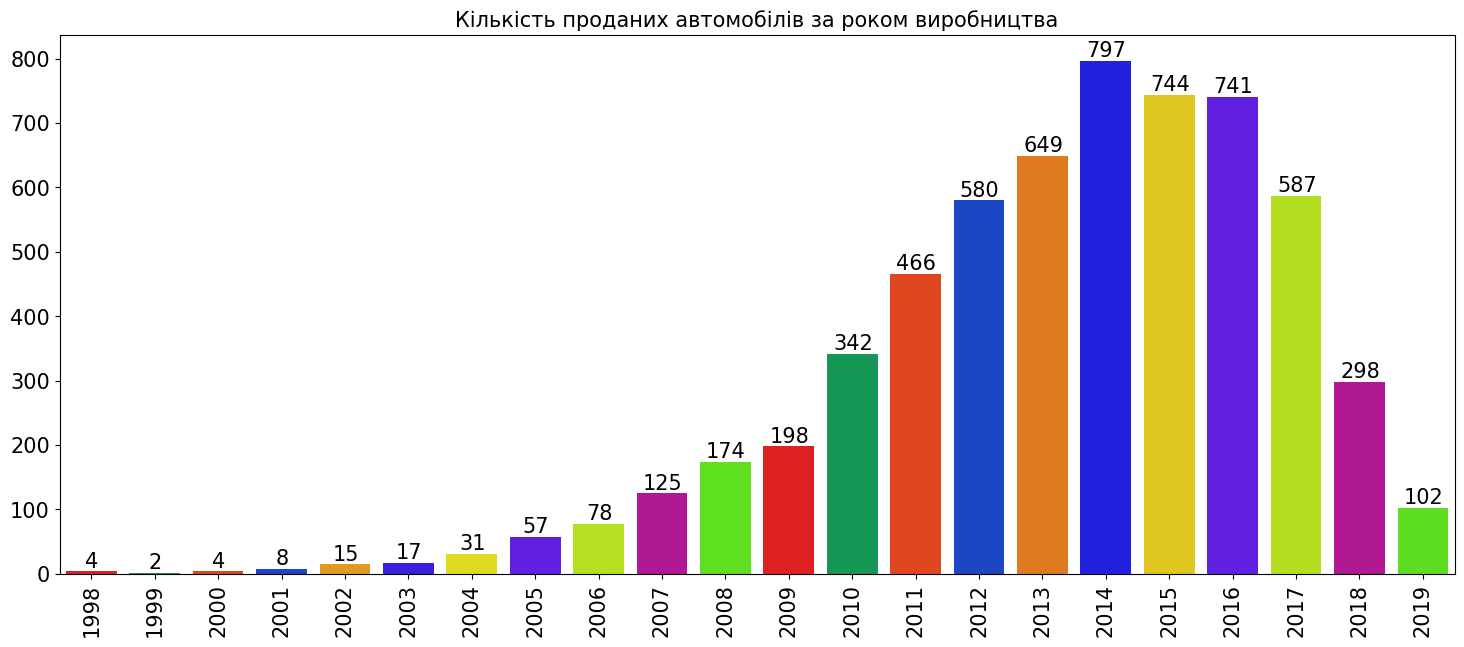

In [ ]:
plt.figure(figsize = (18, 7))
graph = sns.barplot(x = "Years", y = "Cars", data = years, palette = "prism_r")
for p in graph.patches:
  graph.annotate('{:.0f}'.format(p.get_height()),
                 (p.get_x()+0.41, p.get_height()),
                 ha='center', va='bottom', color='black', size = 15)
plt.title("Кількість проданих автомобілів за роком виробництва", size = 15)
plt.xticks(size = 15, rotation = 90)
plt.yticks(size = 15)
plt.xlabel(None)
plt.ylabel(None)
plt.show()

Kilometers Drive by Frequency of Cars

In [ ]:
Kilometers_Driven = df["Kilometers_Driven"].value_counts().to_frame().reset_index().head(10)
Kilometers_Driven.columns = ["Kilometers Drive", "Cars"]
Kilometers_Driven

,Kilometers Drive,Cars
0,60000,82
1,45000,70
2,65000,68
3,50000,61
4,55000,60
5,70000,60
6,30000,54
7,52000,54
8,80000,50
9,75000,50


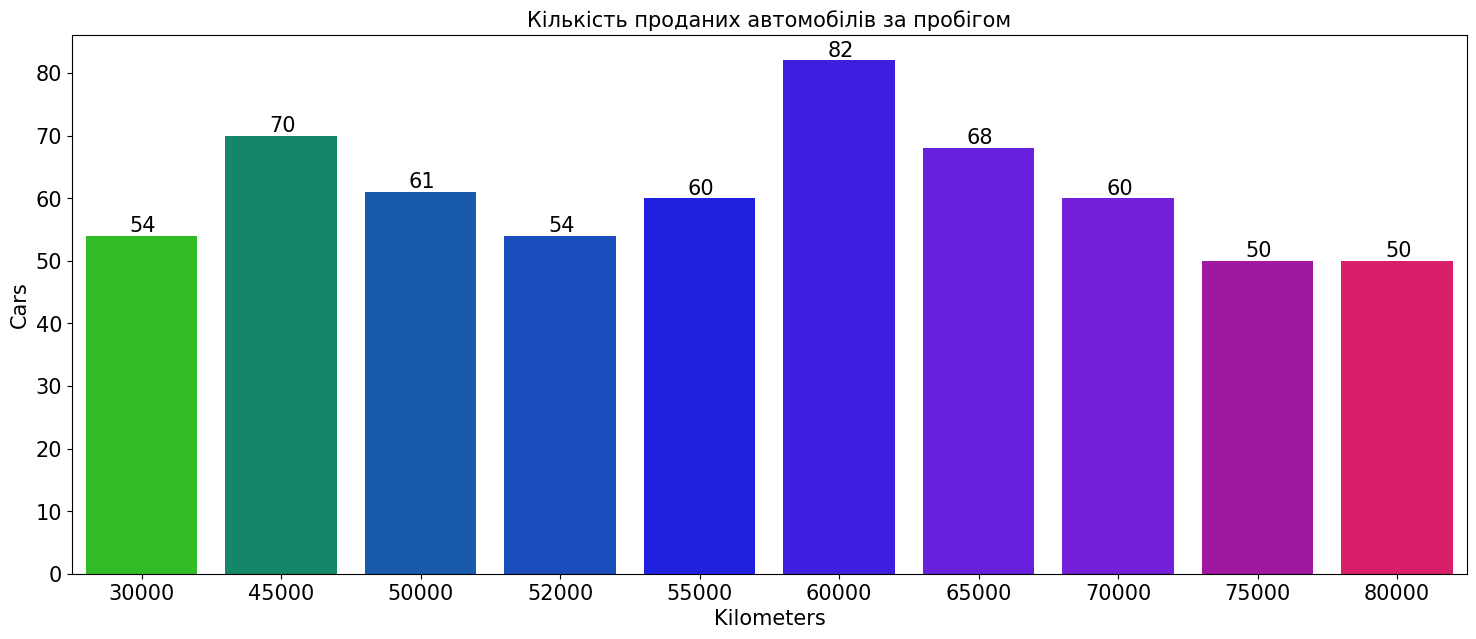

In [ ]:
plt.figure(figsize = (18, 7))
graph = sns.barplot(x = "Kilometers Drive", y = "Cars", data = Kilometers_Driven, palette = "prism_r")
for p in graph.patches:
  graph.annotate('{:.0f}'.format(p.get_height()),
                 (p.get_x()+0.41, p.get_height()),
                 ha='center', va='bottom', color='black', size = 15)
plt.title("Кількість проданих автомобілів за пробігом", size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Kilometers", size = 15)
plt.ylabel("Cars", size = 15)
plt.show()

Fuel Types used by cars

In [ ]:
fuel_cars = df["Fuel_Type"].value_counts().to_frame().reset_index()
fuel_cars.columns = ["Fuel Type", "Cars"]
fuel_cars

,Fuel Type,Cars
0,Diesel,3205
1,Petrol,2746
2,CNG,56
3,LPG,10
4,Electric,2


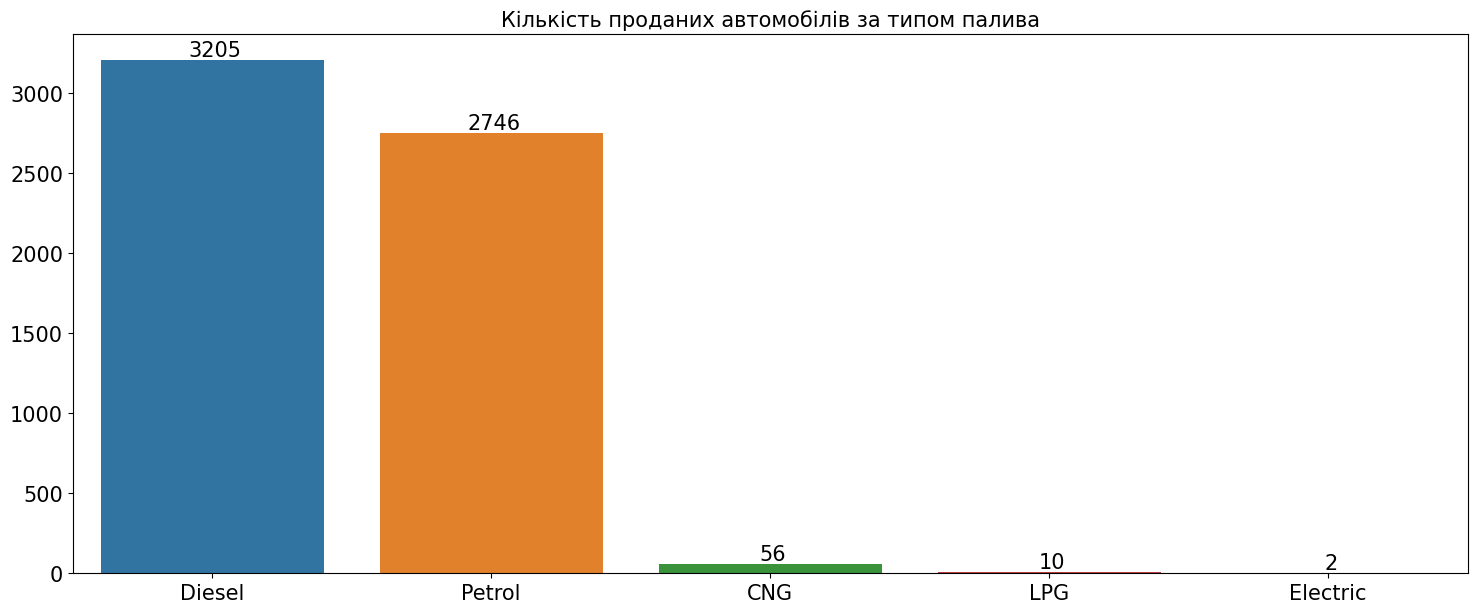

In [ ]:
plt.figure(figsize = (18, 7))
graph = sns.barplot(x = "Fuel Type", y = "Cars", data = fuel_cars)
for p in graph.patches:
  graph.annotate('{:.0f}'.format(p.get_height()),
                 (p.get_x()+0.41, p.get_height()),
                 ha='center', va='bottom', color='black', size = 15)
plt.title("Кількість проданих автомобілів за типом палива", size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel(None)
plt.ylabel(None)
plt.show()

Transmission Type in Cars

In [ ]:
transmission_cars = df["Transmission"].value_counts().to_frame().reset_index()
transmission_cars.columns = ["Transmission Type", "Cars"]
transmission_cars

,Transmission Type,Cars
0,Manual,4299
1,Automatic,1720


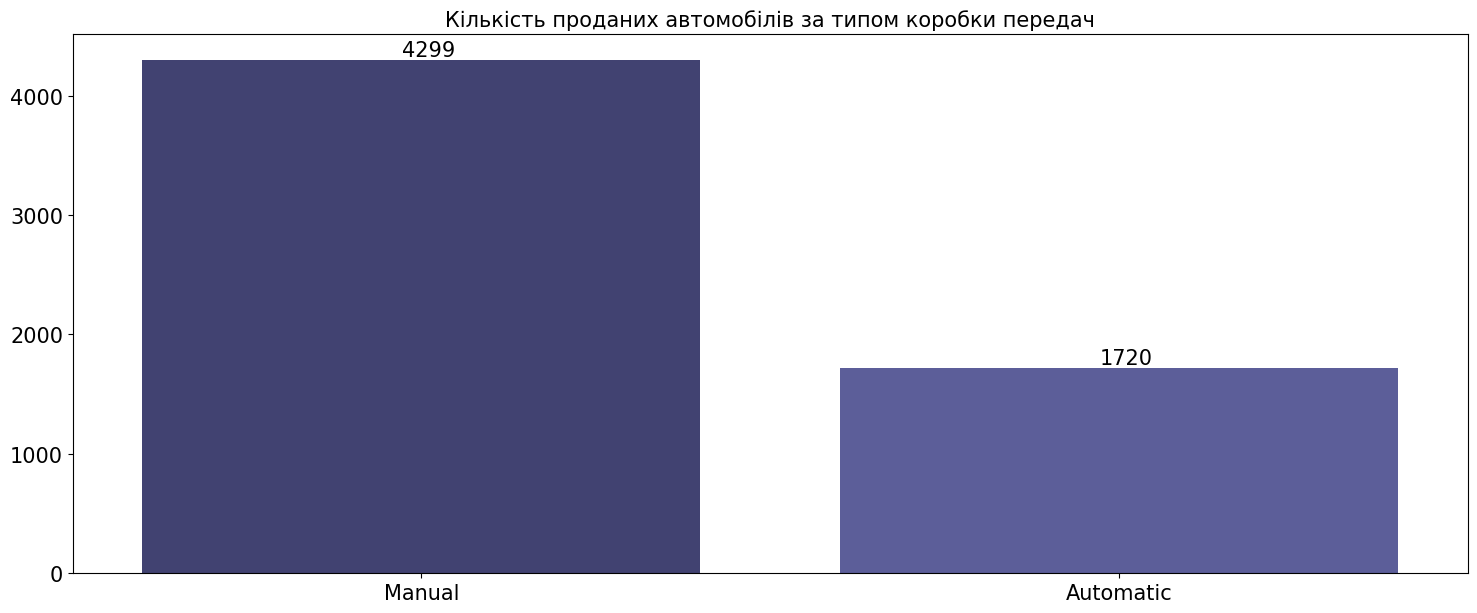

In [ ]:
plt.figure(figsize = (18, 7))
graph = sns.barplot(x = "Transmission Type", y = "Cars", data = transmission_cars, palette = "tab20b")
for p in graph.patches:
  graph.annotate('{:.0f}'.format(p.get_height()),
                 (p.get_x()+0.41, p.get_height()),
                 ha='center', va='bottom', color='black', size = 15)
plt.title("Кількість проданих автомобілів за типом коробки передач", size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel(None)
plt.ylabel(None)
plt.show()

Highest number of cars by Engine CC

In [ ]:
engine = df["Engine CC"].value_counts().to_frame().reset_index().head(10)
engine.columns = ["Engine CC", "Cars"]
engine

,Engine CC,Cars
0,1197.00,606
1,1248.00,512
2,1498.00,304
3,998.00,259
4,2179.00,240
5,1497.00,229
6,1198.00,227
7,1968.00,216
8,1995.00,183
9,1461.00,152


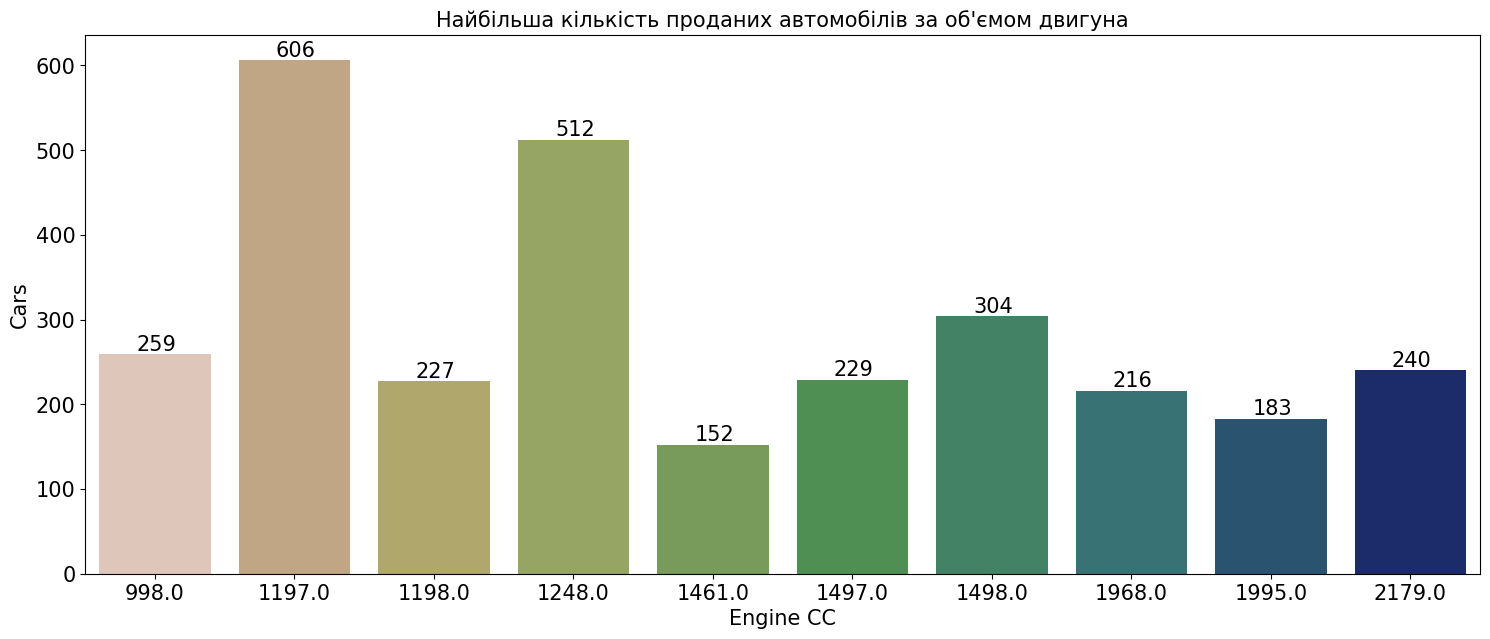

In [ ]:
plt.figure(figsize = (18, 7))
graph = sns.barplot(x = "Engine CC", y = "Cars", data = engine, palette = "gist_earth_r")
for p in graph.patches:
  graph.annotate('{:.0f}'.format(p.get_height()),
                 (p.get_x()+0.41, p.get_height()),
                 ha='center', va='bottom', color='black', size = 15)
plt.title("Найбільша кількість проданих автомобілів за об'ємом двигуна", size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Engine CC", size = 15)
plt.ylabel("Cars", size = 15)
plt.show()

Highest number of cars by Power bph

In [ ]:
power = df["Power bph"].value_counts().to_frame().reset_index()
power.columns = ["Power bph", "Cars"]
power = power.head(10)
power

,Power bph,Cars
0,74.00,235
1,112.77,143
2,98.60,131
3,73.90,125
4,140.00,123
5,88.50,112
6,78.90,111
7,67.10,107
8,67.04,107
9,82.00,101


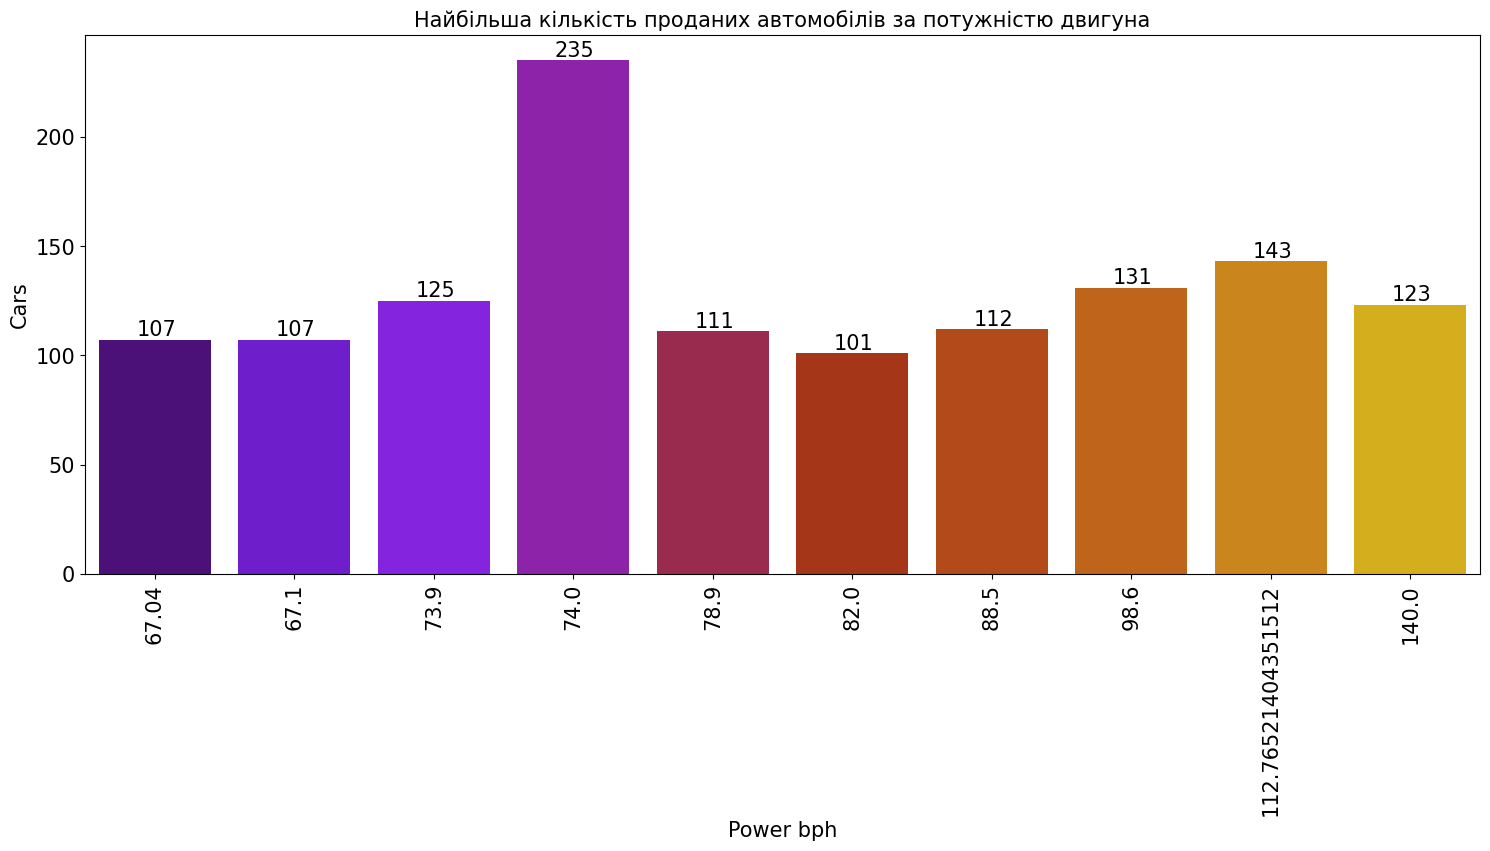

In [ ]:
plt.figure(figsize = (18, 7))
graph = sns.barplot(x = "Power bph", y = "Cars", data = power, palette = "gnuplot")
for p in graph.patches:
  graph.annotate('{:.0f}'.format(p.get_height()),
                 (p.get_x()+0.41, p.get_height()),
                 ha='center', va='bottom', color='black', size = 15)
plt.title("Найбільша кількість проданих автомобілів за потужністю двигуна", size = 15)
plt.xticks(size = 15, rotation = 90)
plt.yticks(size = 15)
plt.xlabel("Power bph", size = 15)
plt.ylabel("Cars", size = 15)
plt.show()

Number of Cars by Highest Power bph

In [ ]:
power = df["Power bph"].value_counts().to_frame().reset_index().sort_values(by = "index", ascending = False).head(10)
power.columns = ["Power bph", "Cars"]
power

,Power bph,Cars
328,560.00,1
321,552.00,1
349,550.00,1
325,503.00,1
323,500.00,1
309,488.10,1
263,450.00,2
287,444.00,2
311,421.00,1
359,402.00,1


Number of Cars by Highest Price

In [ ]:
price = df["Price"].value_counts().to_frame().reset_index().sort_values(by = "index", ascending = False).head(10)
price.columns = ["Price (Lakhs)", "Cars"]
price

,Price (Lakhs),Cars
877,160.00,1
887,120.00,1
671,100.00,1
1166,97.07,1
1360,93.67,1
1362,93.00,1
841,90.00,1
814,85.00,1
1350,83.96,1
410,79.00,2


Deep Analysis

In [ ]:
df.head()

,S.No.,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage kmpl/kg,Engine CC,Power bph,Seats,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.60,998.00,58.16,5.00,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.00,126.20,5.00,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.00,88.70,5.00,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.00,88.76,7.00,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.00,140.80,5.00,17.74


Highest Car Model available for sale by location

In [ ]:
nl = df.groupby(["Location", "Name"])["Name"].agg(["count"]).reset_index().sort_values(by = "count", ascending = False)
nl = nl.drop_duplicates("Location", keep = "first")
nl.columns = ["City", "Car Model", "Cars"]
nl

,City,Car Model,Cars
1950,Hyderabad,Maruti Ritz VDi,12
3152,Kolkata,Maruti Swift Dzire VDI,9
1474,Delhi,Mahindra XUV500 W8 2WD,9
1003,Coimbatore,Hyundai Grand i10 AT Asta,8
4102,Pune,Maruti Swift VDI,8
2715,Kochi,Mahindra XUV500 W8 2WD,8
2220,Jaipur,Hyundai EON Era Plus,7
3743,Mumbai,Skoda Superb Elegance 1.8 TSI AT,7
188,Bangalore,Audi A4 2.0 TDI 177 Bhp Premium Plus,5
717,Chennai,Maruti Swift VDI,5


Car Models available for sale by highest Engine CC

In [ ]:
ce = df.groupby(["Engine CC", "Name"])["Name"].agg(["count"]).reset_index().sort_values(by = "Engine CC", ascending = False)
ce = ce.drop_duplicates("Name", keep = "first")
ce.columns = ["Engine CC", "Car Model", "Cars"]
ce = ce.head(10)
ce

,Engine CC,Car Model,Cars
1887,5998.00,Bentley Continental Flying Spur,1
1886,5461.00,Mercedes-Benz SLK-Class 55 AMG,1
1885,5461.00,Mercedes-Benz SL-Class SL 500,1
1884,5461.00,Mercedes-Benz S Class 2005 2013 S 500,1
1883,5204.00,Lamborghini Gallardo Coupe,1
1882,5000.00,Jaguar XJ 5.0 L V8 Supercharged,1
1881,5000.00,Jaguar F Type 5.0 V8 S,1
1880,4951.00,Ford Mustang V8,1
1879,4806.00,Porsche Panamera 2010 2013 Diesel,1
1878,4806.00,Porsche Panamera 2010 2013 4S,1


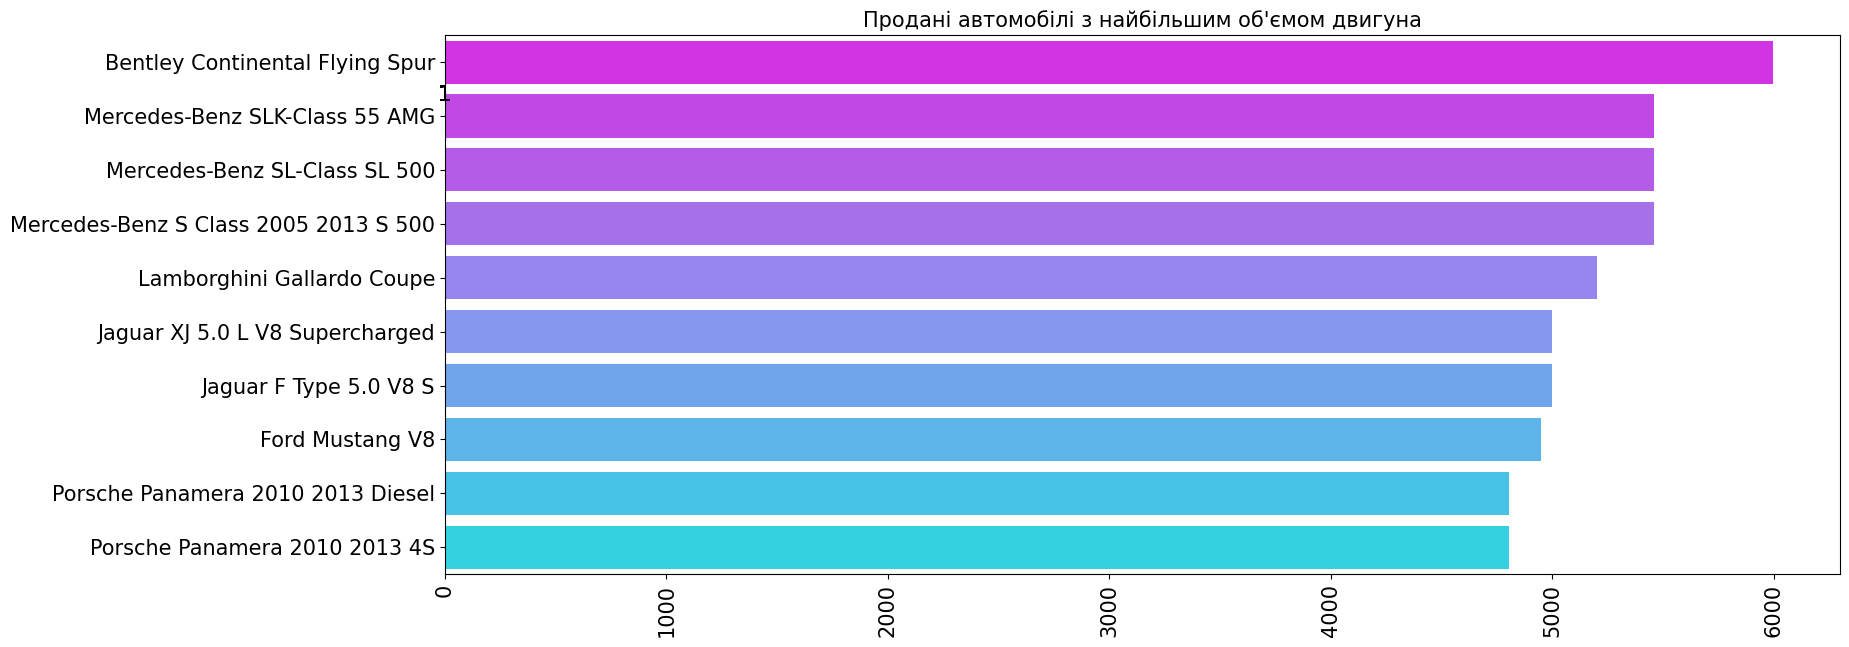

In [ ]:
plt.figure(figsize = (18, 7))
graph = sns.barplot(x = "Engine CC", y = "Car Model", data = ce, palette = "cool_r")
for p in graph.patches:
  graph.annotate('{:.0f}'.format(p.get_height()),
                 (p.get_x()+0.05, p.get_height()),
                 ha='center', va='bottom', color='black', size = 15)
plt.title("Продані автомобілі з найбільшим об'ємом двигуна", size = 15)
plt.xticks(size = 15, rotation = 90)
plt.yticks(size = 15)
plt.xlabel(None)
plt.ylabel(None)
plt.show()

Car Models available for sale by highest Power bph

In [ ]:
cp = df.groupby(["Power bph", "Name"])["Name"].agg(["count"]).reset_index().sort_values(by = "Power bph", ascending = False)
cp = cp.drop_duplicates("Name", keep = "first")
cp.columns = ["Power bph", "Car Model", "Cars"]
cp = cp.head(10)
cp

,Power bph,Car Model,Cars
1967,560.00,Lamborghini Gallardo Coupe,1
1966,552.00,Bentley Continental Flying Spur,1
1965,550.00,Porsche Cayenne Turbo S,1
1964,503.00,Jaguar XJ 5.0 L V8 Supercharged,1
1963,500.00,Porsche Cayenne 2009-2014 Turbo,1
1962,488.10,Jaguar F Type 5.0 V8 S,1
1961,450.00,BMW 6 Series 650i Coupe,1
1960,450.00,BMW 6 Series 630i Coupe,1
1959,444.00,Audi RS5 Coupe,2
1958,421.00,Mercedes-Benz SLK-Class 55 AMG,1


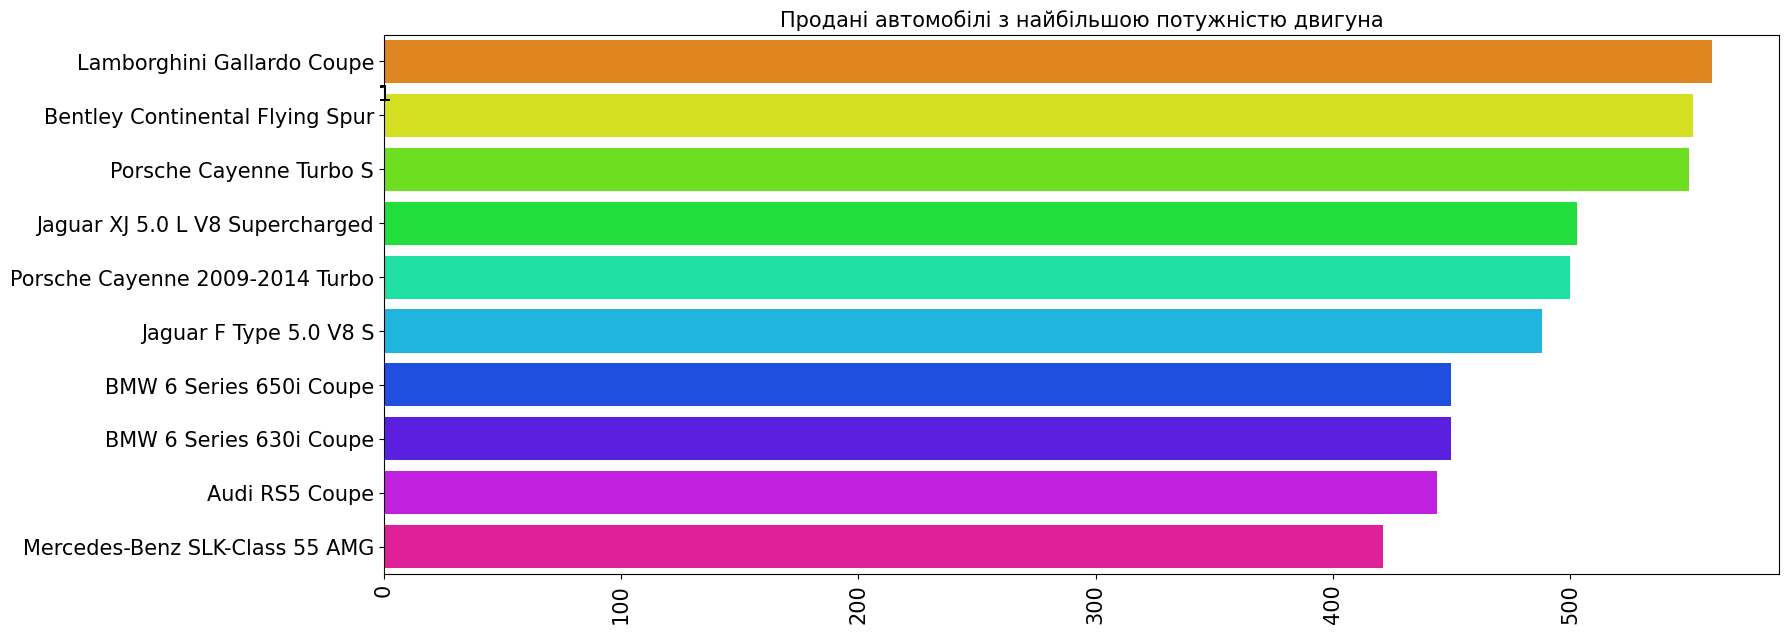

In [ ]:
plt.figure(figsize = (18, 7))
graph = sns.barplot(x = "Power bph", y = "Car Model", data = cp, palette = "hsv")
for p in graph.patches:
  graph.annotate('{:.0f}'.format(p.get_height()),
                 (p.get_x()+0.1, p.get_height()),
                 ha='center', va='bottom', color='black', size = 15)
plt.title("Продані автомобілі з найбільшою потужністю двигуна", size = 15)
plt.xticks(size = 15, rotation = 90)
plt.yticks(size = 15)
plt.xlabel(None)
plt.ylabel(None)
plt.show()

Cars for sale in Location by Transmission

In [24]:
lt = df.groupby(["Location", "Transmission"])["Transmission"].agg(["count"]).reset_index()
lt.columns = ["City", "Transmission", "Cars"]
lt.sort_values(by = "Cars", ascending = False)

,City,Transmission,Cars
11,Hyderabad,Manual,546
19,Mumbai,Manual,487
21,Pune,Manual,478
17,Kolkata,Manual,455
15,Kochi,Manual,446
7,Coimbatore,Manual,389
9,Delhi,Manual,383
5,Chennai,Manual,374
13,Jaipur,Manual,361
18,Mumbai,Automatic,303


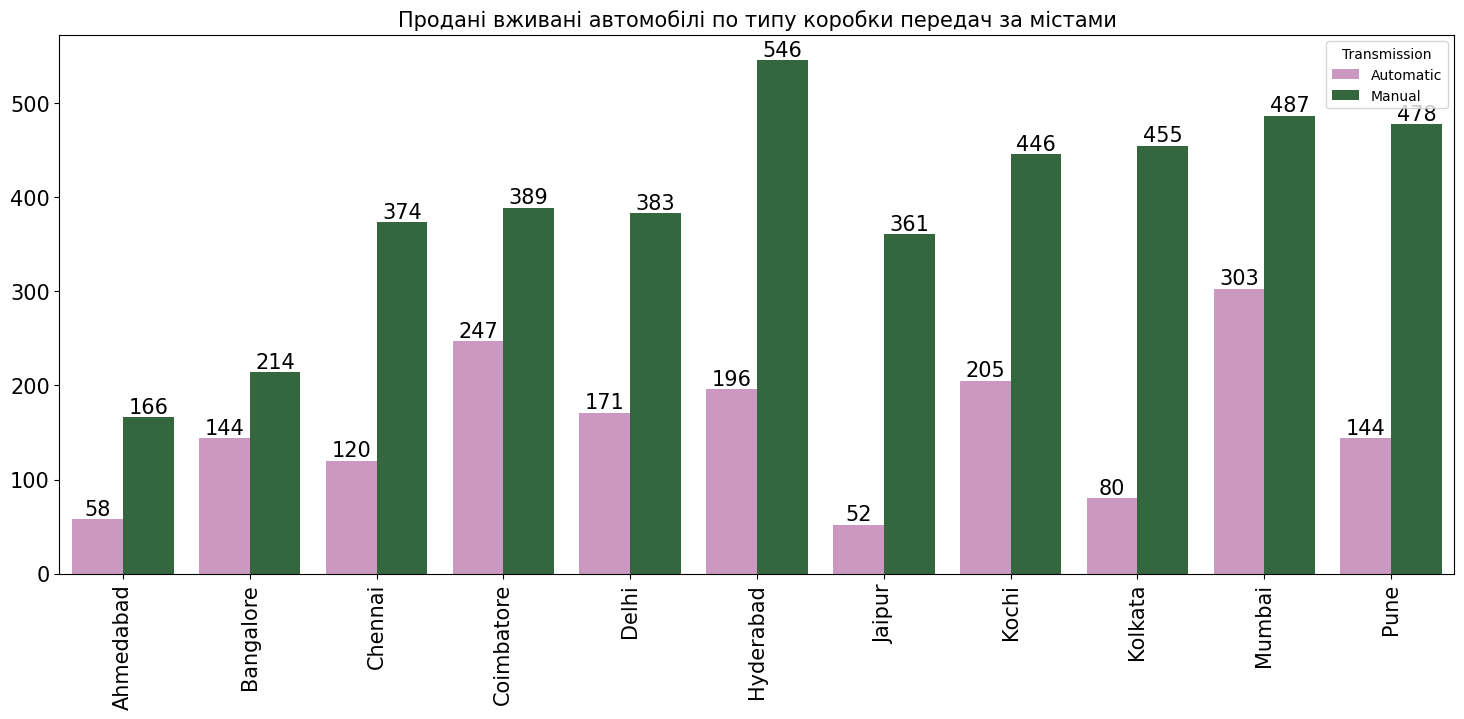

In [25]:
plt.figure(figsize = (18, 7))
graph = sns.barplot(x = "City", y = "Cars", hue = "Transmission", data = lt, palette = "cubehelix_r")
for p in graph.patches:
  graph.annotate('{:.0f}'.format(p.get_height()),
                 (p.get_x()+0.2, p.get_height()),
                 ha='center', va='bottom', color='black', size = 15)
plt.title("Продані вживані автомобілі по типу коробки передач за містами", size = 15)
plt.xticks(size = 15, rotation = 90)
plt.yticks(size = 15)
plt.xlabel(None)
plt.ylabel(None)
plt.show()

Cars for sale (Engine CC) by Location

In [26]:
el = df.groupby("Location")["Engine CC"].agg(["min", "max"]).reset_index().sort_values(by = "max", ascending = False)
el.columns = ["City", "Min Engine CC", "Max Engine CC"]
el

,City,Min Engine CC,Max Engine CC
5,Hyderabad,624.00,5998.00
1,Bangalore,624.00,5461.00
8,Kolkata,793.00,5461.00
4,Delhi,796.00,5204.00
3,Coimbatore,624.00,5000.00
7,Kochi,624.00,4951.00
9,Mumbai,796.00,4806.00
10,Pune,624.00,3498.00
2,Chennai,72.00,3200.00
6,Jaipur,624.00,3198.00


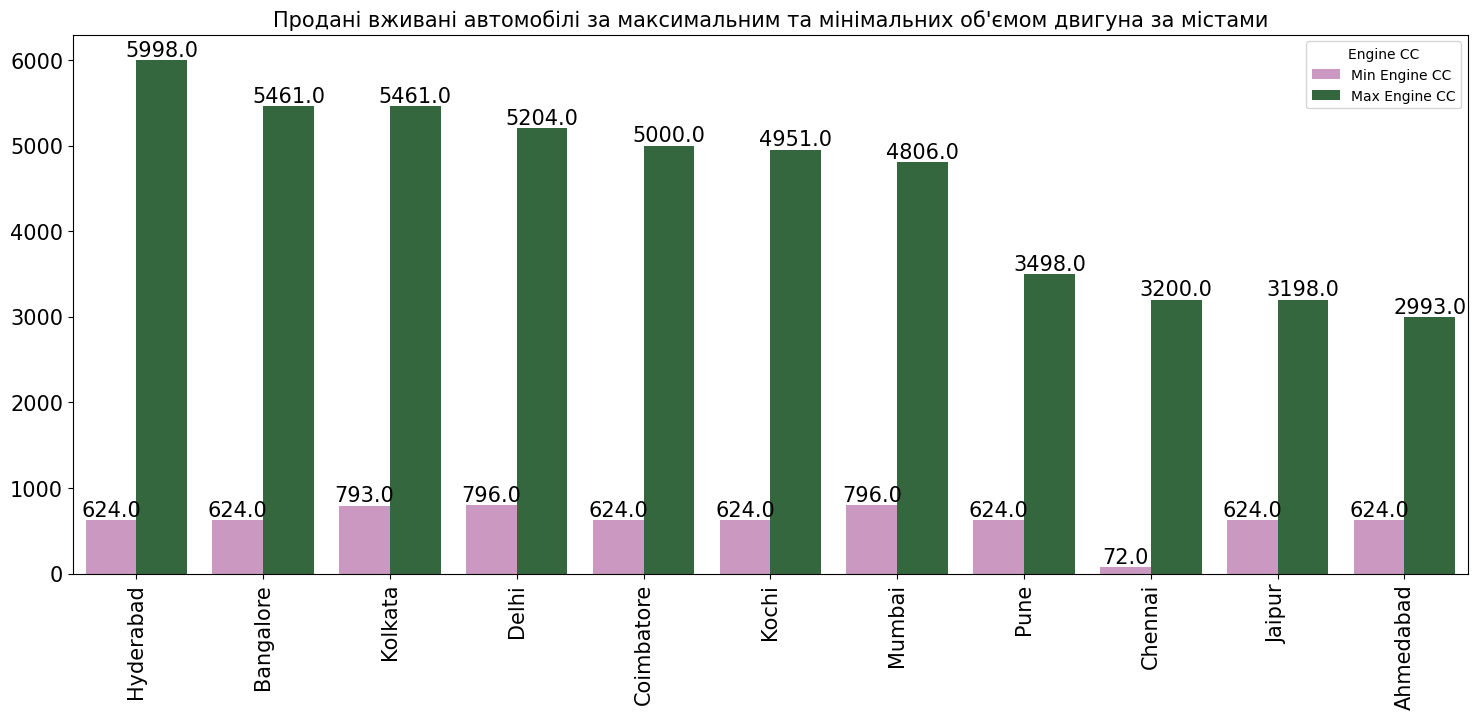

In [27]:
el = el.melt("City", var_name = "Engine CC", value_name = "Size")
plt.figure(figsize = (18, 7))
graph = sns.barplot(x = "City", y = "Size", hue = "Engine CC", data = el, palette = "cubehelix_r")
for p in graph.patches:
  graph.annotate('{:.01f}'.format(p.get_height()),
                 (p.get_x()+0.2, p.get_height()),
                 ha='center', va='bottom', color='black', size = 15)
plt.title("Продані вживані автомобілі за максимальним та мінімальних об'ємом двигуна за містами", size = 15)
plt.xticks(size = 15, rotation = 90)
plt.yticks(size = 15)
plt.xlabel(None)
plt.ylabel(None)
plt.show()

Fuel Type of cars for sale by Power bph

In [ ]:
fp = df.groupby("Fuel_Type")["Power bph"].agg(["min", "mean", "max"]).reset_index()
fp.columns = ["Fuel", "Min Power bph", "Avg Power bph", "Max Power bph"]
fp

,Fuel,Min Power bph,Avg Power bph,Max Power bph
0,CNG,38.40,65.69,138.00
1,Diesel,35.50,127.66,394.30
2,Electric,41.00,57.00,73.00
3,LPG,55.20,59.91,68.05
4,Petrol,34.20,97.62,560.00


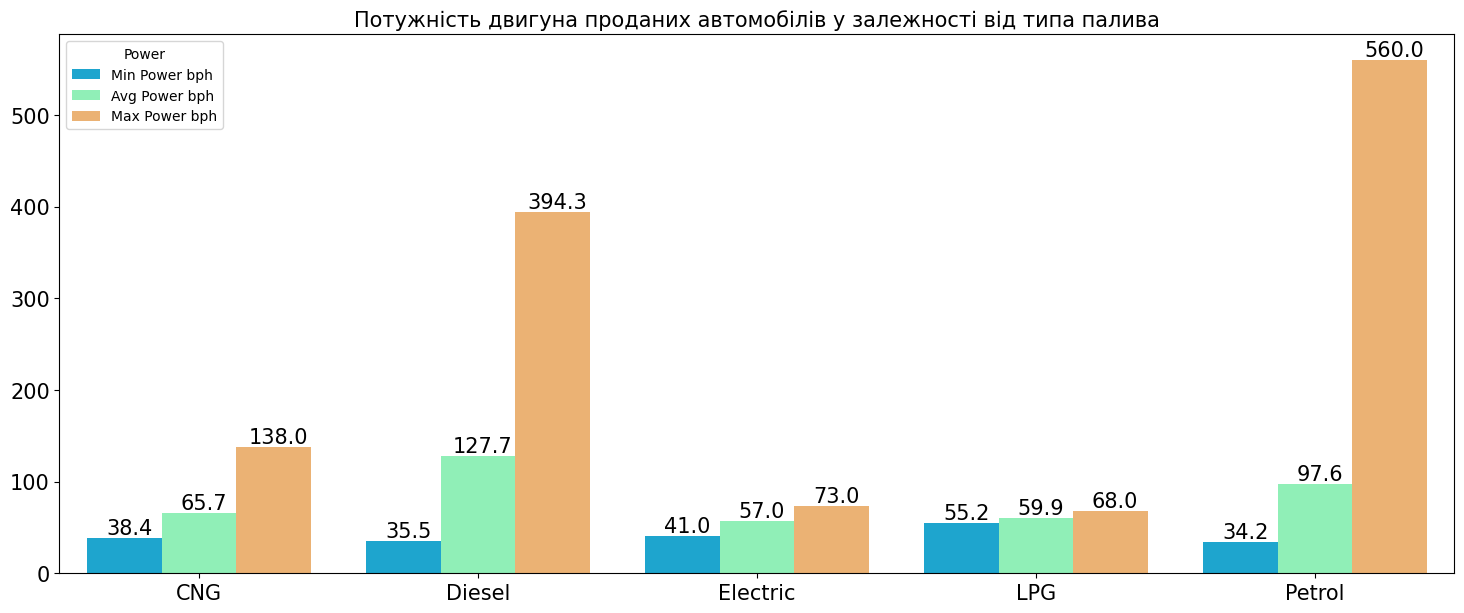

In [ ]:
fp = fp.melt("Fuel", var_name = "Power", value_name = "bph")
plt.figure(figsize = (18, 7))
graph = sns.barplot(x = "Fuel", y = "bph", hue = "Power", data = fp, palette = "rainbow")
for p in graph.patches:
  graph.annotate('{:.01f}'.format(p.get_height()),
                 (p.get_x()+0.15, p.get_height()),
                 ha='center', va='bottom', color='black', size = 15)
plt.title("Потужність двигуна проданих автомобілів у залежності від типа палива", size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel(None)
plt.ylabel(None)
plt.show()

Transmission Type of cars for sale by Year

In [ ]:
ty = df.groupby(["Year", "Transmission"])["Transmission"].agg(["count"]).reset_index()
ty.columns = ["Year", "Transmission", "Cars"]
ty.sort_values(by = "Cars")

,Year,Transmission,Cars
0,1998,Automatic,1
2,1999,Manual,2
6,2003,Automatic,2
1,1998,Manual,3
3,2000,Manual,4
8,2004,Automatic,6
4,2001,Manual,8
10,2005,Automatic,9
12,2006,Automatic,11
5,2002,Manual,15


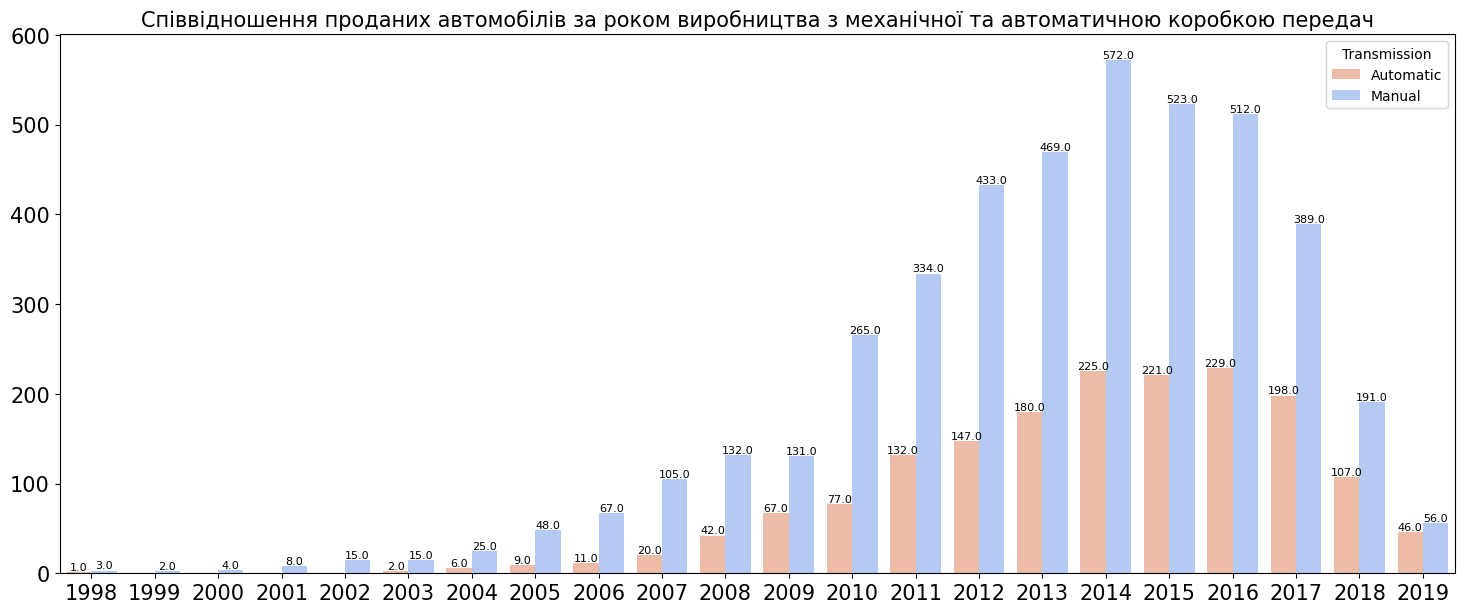

In [ ]:
plt.figure(figsize = (18, 7))
graph = sns.barplot(x = "Year", y = "Cars", hue = "Transmission", data = ty, palette = "coolwarm_r")
for p in graph.patches:
  graph.annotate('{:.01f}'.format(p.get_height()),
                 (p.get_x()+0.2, p.get_height()),
                 ha='center', va='bottom', color='black', size = 8)
plt.title("Співвідношення проданих автомобілів за роком виробництва з механічної та автоматичною коробкою передач", size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel(None)
plt.ylabel(None)
plt.show()

Transmission Type of cars for sale by Mileage kmpl/kg

In [ ]:
tm = df.groupby("Transmission")["Mileage kmpl/kg"].agg(["count", "sum", "min", "mean", "max"]).reset_index()
tm.columns = ["Transmission", "Cars", "Total Mileage kmpl/kg", "Min Mileage kmpl/kg", "Avg Mileage kmpl/kg", "Max Mileage kmpl/kg"]
tm

,Transmission,Cars,Total Mileage kmpl/kg,Min Mileage kmpl/kg,Avg Mileage kmpl/kg,Max Mileage kmpl/kg
0,Automatic,1718,27006.40,0.00,15.72,28.40
1,Manual,4299,82111.66,0.00,19.10,33.54


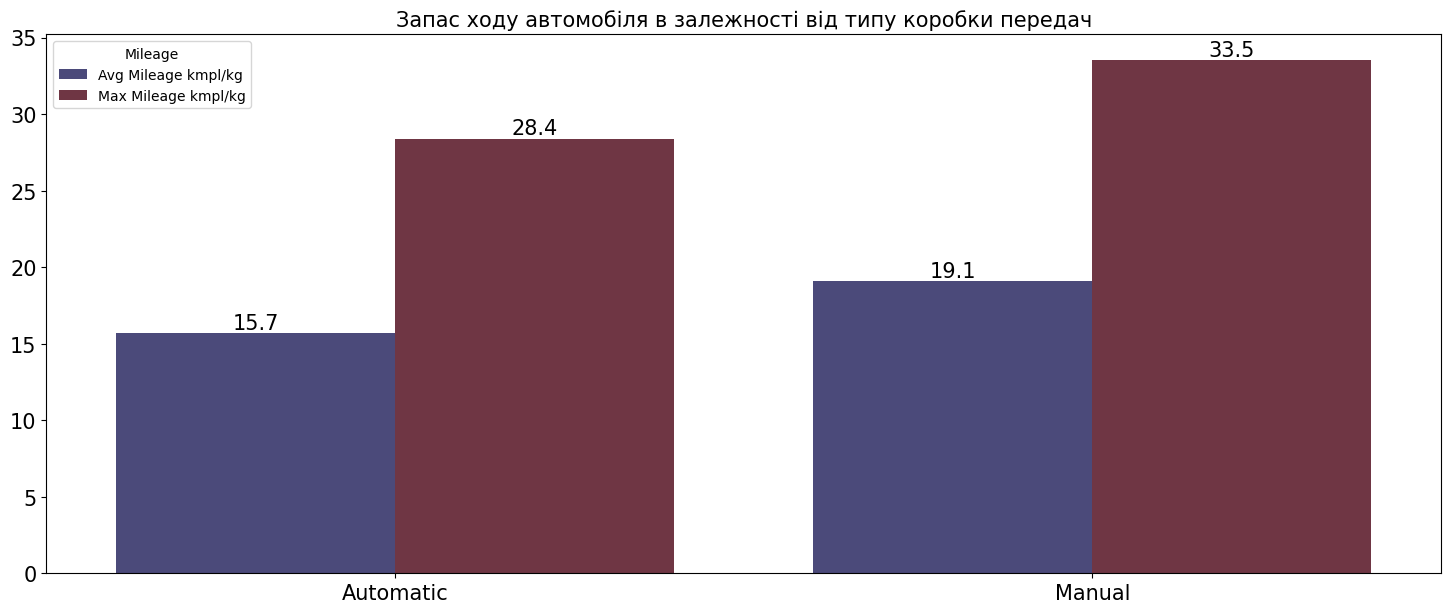

In [ ]:
tm = tm[["Transmission", "Avg Mileage kmpl/kg", "Max Mileage kmpl/kg"]]
tm = tm.melt("Transmission", var_name = "Mileage", value_name = "kmpl/kg")
plt.figure(figsize = (18, 7))
graph = sns.barplot(x = "Transmission", y = "kmpl/kg", hue = "Mileage", data = tm, palette = "icefire")
for p in graph.patches:
  graph.annotate('{:.01f}'.format(p.get_height()),
                 (p.get_x()+0.2, p.get_height()),
                 ha='center', va='bottom', color='black', size = 15)
plt.title("Запас ходу автомобіля в залежності від типу коробки передач", size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel(None)
plt.ylabel(None)
plt.show()

Linear Regression

In [ ]:
df.head()

,S.No.,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage kmpl/kg,Engine CC,Power bph,Seats,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.60,998.00,58.16,5.00,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.00,126.20,5.00,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.00,88.70,5.00,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.00,88.76,7.00,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.00,140.80,5.00,17.74


Linear Regression (Year | Price)



In [ ]:
X = df[["Year"]]
y = df["Price"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 50)

standardScaler = StandardScaler()
standardScaler.fit(x_train)
x_train = standardScaler.transform(x_train)
x_test = standardScaler.transform(x_test)

lr = LinearRegression()

lr.fit(x_train, y_train)

y_hat = lr.predict(x_test)

pd.DataFrame({"Actual": y_test, "Predicted": y_hat}).head()

,Actual,Predicted
4859,5.38,13.12
2650,12.90,13.12
727,3.25,6.02
3960,10.82,14.14
421,4.35,9.06


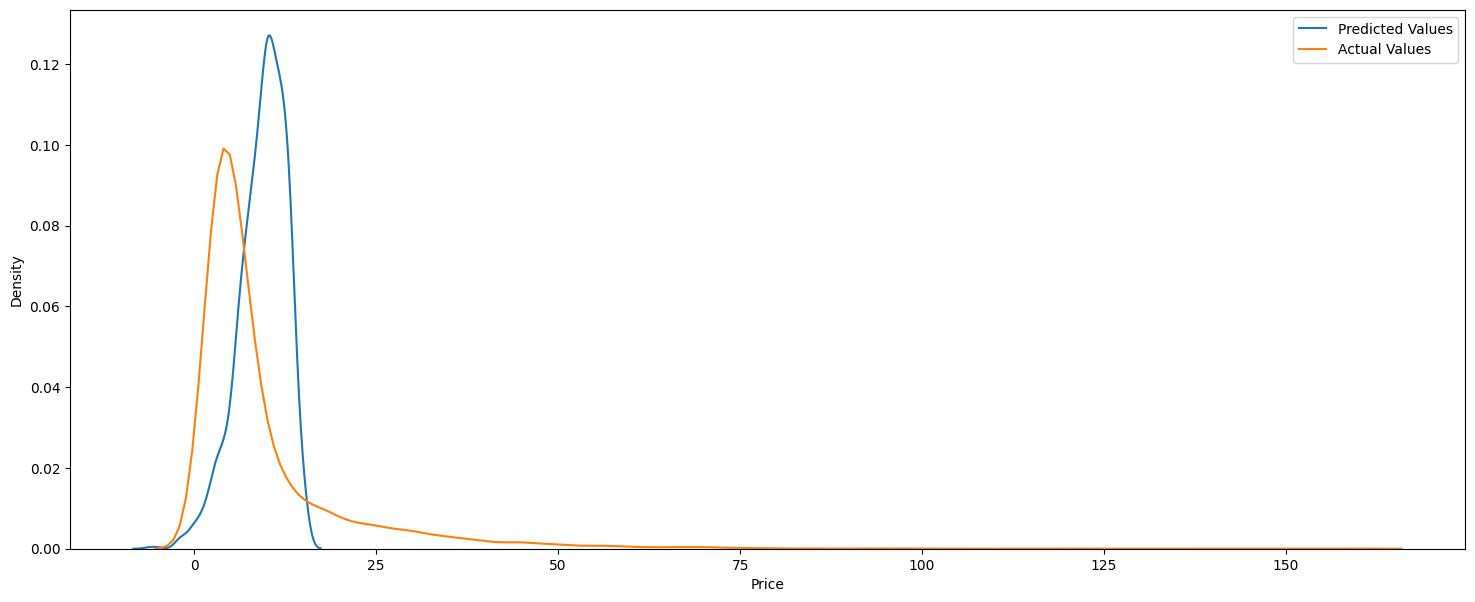

In [ ]:
plt.figure(figsize=(18, 7))
ax1 = sns.distplot(y_hat, hist=False, label='Predicted Values')
sns.distplot(y, hist=False, label='Actual Values', ax=ax1)
plt.legend()
plt.show()
plt.close()
plt.show()

In [ ]:
# Performance
print("Mean Squared Error = ", mean_squared_error(y_test, y_hat, squared = True))
print("Root Mean Squared Error = ", mean_squared_error(y_test, y_hat, squared = False))
print("Mean Absolute Error = ", mean_absolute_error(y_test, y_hat))
print("R-Squared: = ", r2_score(y_test, y_hat))

Mean Squared Error =  110.53237998480884
Root Mean Squared Error =  10.513438066817574
Mean Absolute Error =  6.799484666973446
R-Squared: =  0.10492931084611967


Linear Regression (Engine CC | Price)

In [ ]:
X = df[["Engine CC"]]
y = df["Price"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 50)

standardScaler = StandardScaler()
standardScaler.fit(x_train)
x_train = standardScaler.transform(x_train)
x_test = standardScaler.transform(x_test)

lr = LinearRegression()

lr.fit(x_train, y_train)

y_hat = lr.predict(x_test)

pd.DataFrame({"Actual": y_test, "Predicted": y_hat}).head()

,Actual,Predicted
4859,5.38,4.25
2650,12.90,9.01
727,3.25,4.26
3960,10.82,6.71
421,4.35,7.91


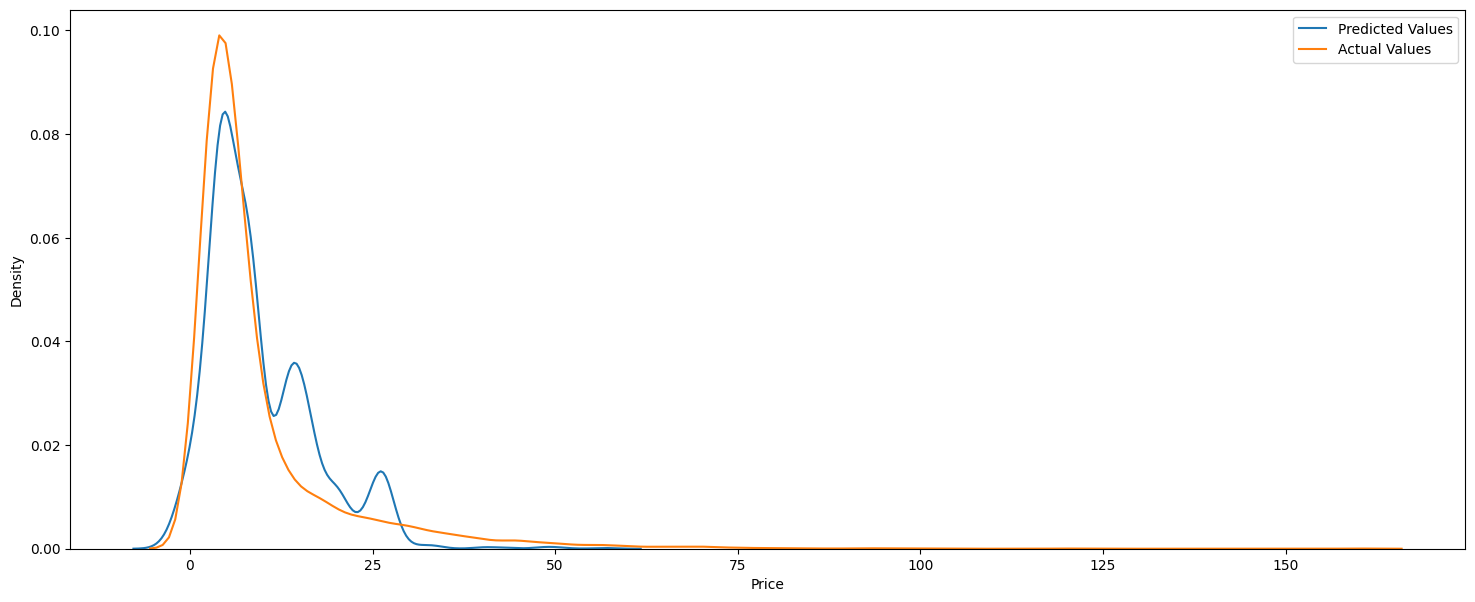

In [ ]:
plt.figure(figsize=(18, 7))
ax1 = sns.distplot(y_hat, hist=False, label='Predicted Values')
sns.distplot(y, hist=False, label='Actual Values', ax=ax1)
plt.legend()
plt.show()
plt.close()
plt.show()

In [ ]:
# Performance
print("Mean Squared Error = ", mean_squared_error(y_test, y_hat, squared = True))
print("Root Mean Squared Error = ", mean_squared_error(y_test, y_hat, squared = False))
print("Mean Absolute Error = ", mean_absolute_error(y_test, y_hat))
print("R-Squared: = ", r2_score(y_test, y_hat))

Mean Squared Error =  70.86117267463437
Root Mean Squared Error =  8.417907856150148
Mean Absolute Error =  5.050974470273945
R-Squared: =  0.4261793813825948


Linear Regression (Power bph | Price)

In [ ]:
X = df[["Power bph"]]
y = df["Price"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 50)

standardScaler = StandardScaler()
standardScaler.fit(x_train)
x_train = standardScaler.transform(x_train)
x_test = standardScaler.transform(x_test)

lr = LinearRegression()

lr.fit(x_train, y_train)

y_hat = lr.predict(x_test)

pd.DataFrame({"Actual": y_test, "Predicted": y_hat}).head()

,Actual,Predicted
4859,5.38,5.28
2650,12.90,11.61
727,3.25,4.18
3960,10.82,5.58
421,4.35,7.40


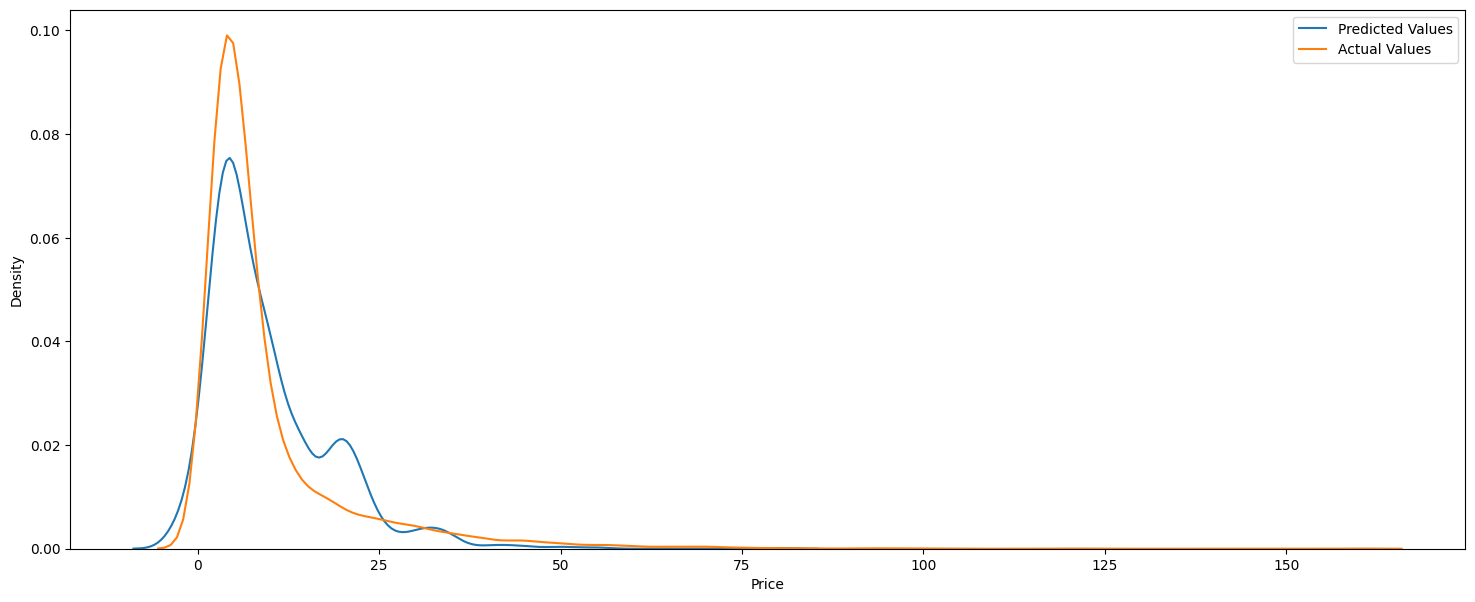

In [ ]:
plt.figure(figsize=(18, 7))
ax1 = sns.distplot(y_hat, hist=False, label='Predicted Values')
sns.distplot(y, hist=False, label='Actual Values', ax=ax1)
plt.legend()
plt.show()
plt.close()
plt.show()

In [ ]:
# Performance
print("Mean Squared Error = ", mean_squared_error(y_test, y_hat, squared = True))
print("Root Mean Squared Error = ", mean_squared_error(y_test, y_hat, squared = False))
print("Mean Absolute Error = ", mean_absolute_error(y_test, y_hat))
print("R-Squared: = ", r2_score(y_test, y_hat))

Mean Squared Error =  49.60555770842773
Root Mean Squared Error =  7.043121304395355
Mean Absolute Error =  4.319770181309899
R-Squared: =  0.5983034045765845


Linear Regression (Seats | Price)

In [ ]:
X = df[["Seats"]]
y = df["Price"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 50)

standardScaler = StandardScaler()
standardScaler.fit(x_train)
x_train = standardScaler.transform(x_train)
x_test = standardScaler.transform(x_test)

lr = LinearRegression()

lr.fit(x_train, y_train)

y_hat = lr.predict(x_test)

pd.DataFrame({"Actual": y_test, "Predicted": y_hat}).head()

,Actual,Predicted
4859,5.38,9.31
2650,12.90,9.31
727,3.25,9.31
3960,10.82,9.31
421,4.35,9.31


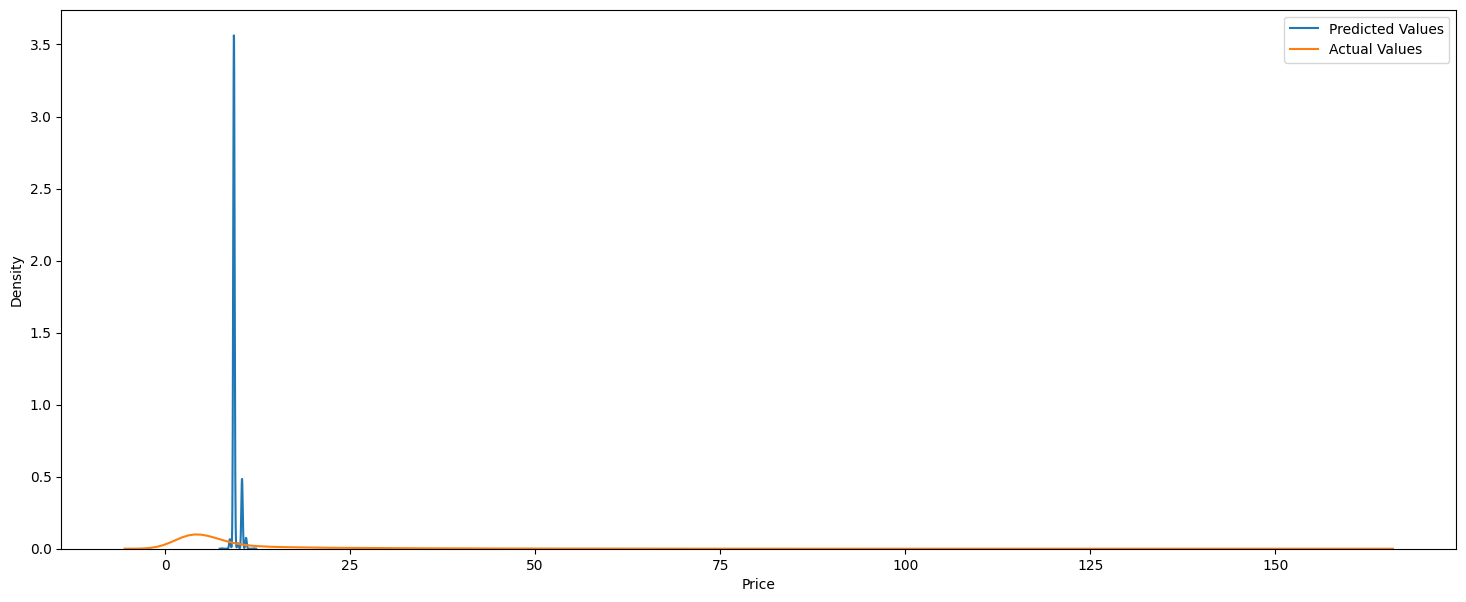

In [ ]:
plt.figure(figsize=(18, 7))
ax1 = sns.distplot(y_hat, hist=False, label='Predicted Values')
sns.distplot(y, hist=False, label='Actual Values', ax=ax1)
plt.legend()
plt.show()
plt.close()
plt.show()

In [ ]:
# Performance
print("Mean Squared Error = ", mean_squared_error(y_test, y_hat, squared = True))
print("Root Mean Squared Error = ", mean_squared_error(y_test, y_hat, squared = False))
print("Mean Absolute Error = ", mean_absolute_error(y_test, y_hat))
print("R-Squared: = ", r2_score(y_test, y_hat))

Mean Squared Error =  122.90133507192914
Root Mean Squared Error =  11.086087455542156
Mean Absolute Error =  7.132753701258022
R-Squared: =  0.00476780925297815


Multiple Linear Regression

In [ ]:
X = df[["Year", "Engine CC", "Power bph", "Seats"]]
y = df["Price"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 50)

standardScaler = StandardScaler()
standardScaler.fit(x_train)
x_train = standardScaler.transform(x_train)
x_test = standardScaler.transform(x_test)

lr = LinearRegression()

lr.fit(x_train, y_train)

y_hat = lr.predict(x_test)

pd.DataFrame({"Actual": y_test, "Predicted": y_hat}).head()


,Actual,Predicted
4859,5.38,8.71
2650,12.90,15.10
727,3.25,0.59
3960,10.82,10.68
421,4.35,7.29


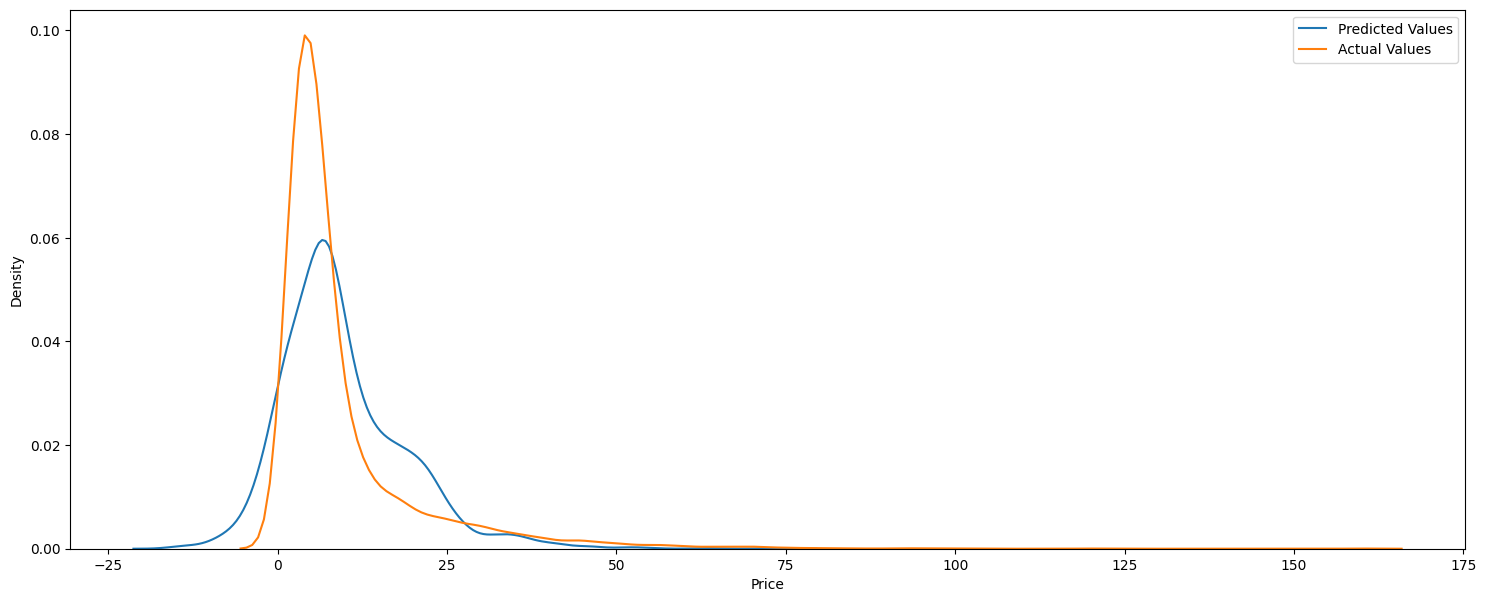

In [ ]:
plt.figure(figsize=(18, 7))
ax1 = sns.distplot(y_hat, hist=False, label='Predicted Values')
sns.distplot(y, hist=False, label='Actual Values', ax=ax1)
plt.legend()
plt.savefig('Multiple Linear Regression.png')
plt.show()
plt.close()
plt.show()

In [ ]:
# Performance
print("Mean Squared Error = ", mean_squared_error(y_test, y_hat, squared = True))
print("Root Mean Squared Error = ", mean_squared_error(y_test, y_hat, squared = False))
print("Mean Absolute Error = ", mean_absolute_error(y_test, y_hat))
print("R-Squared: = ", r2_score(y_test, y_hat))

Mean Squared Error =  38.189323569345085
Root Mean Squared Error =  6.179751092830931
Mean Absolute Error =  3.8963336711624574
R-Squared: =  0.6907499488364215


Random Forest

In [ ]:
df.head()

,S.No.,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage kmpl/kg,Engine CC,Power bph,Seats,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.60,998.00,58.16,5.00,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.00,126.20,5.00,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.00,88.70,5.00,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.00,88.76,7.00,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.00,140.80,5.00,17.74


Random Forest (Kilometers | Price)

In [ ]:
X = df[["Year"]]
y = df["Price"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

standardScaler = StandardScaler()
standardScaler.fit(x_train)
x_train = standardScaler.transform(x_train)
x_test = standardScaler.transform(x_test)

rf = RandomForestRegressor(n_estimators = 100, random_state = 1)

rf.fit(x_train, y_train)

y_hat = rf.predict(x_test)

pd.DataFrame({"Actual": y_test, "Predicted": y_hat}).head()

,Actual,Predicted
5150,7.25,9.59
2164,4.25,4.88
1136,3.90,7.11
5641,8.41,7.11
1515,13.48,13.75


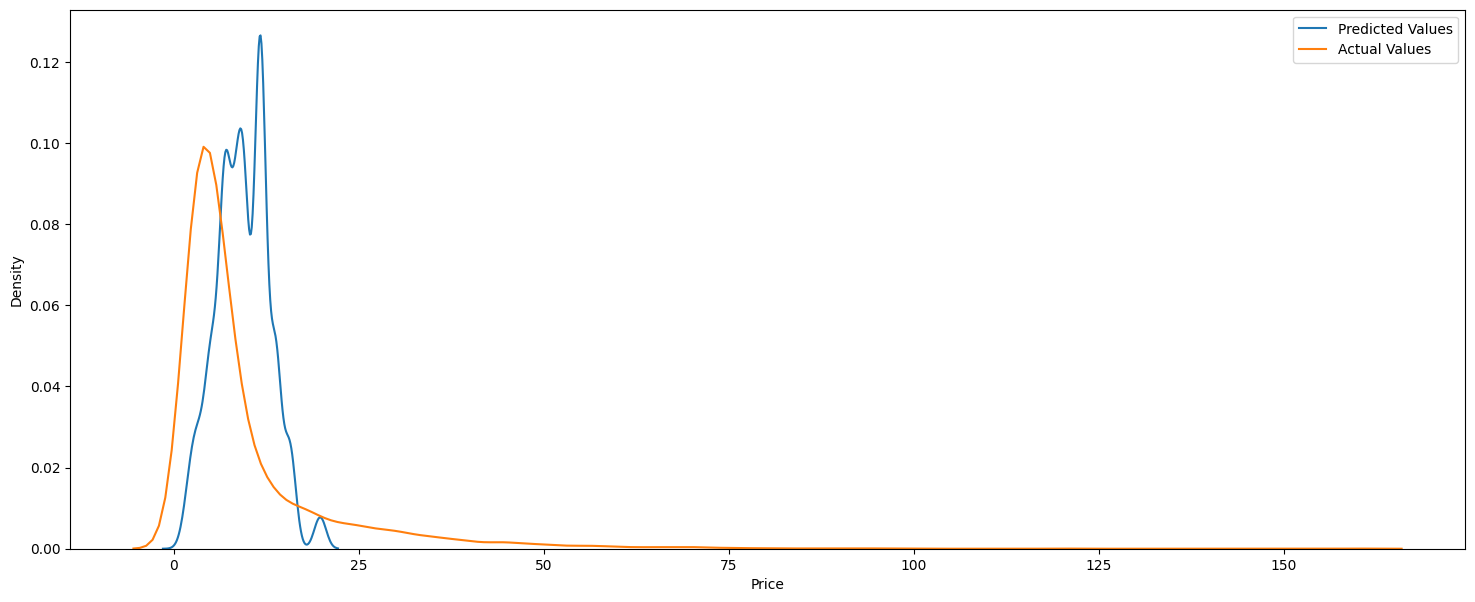

In [ ]:
plt.figure(figsize=(18, 7))
ax1 = sns.distplot(y_hat, hist=False, label='Predicted Values')
sns.distplot(y, hist=False, label='Actual Values', ax=ax1)
plt.legend()
plt.title('')
plt.savefig('Random Forest Price by Year.png')
plt.show()
plt.close()
plt.show()

In [ ]:
# Performance
print("Mean Squared Error = ", mean_squared_error(y_test, y_hat, squared = True))
print("Root Mean Squared Error = ", mean_squared_error(y_test, y_hat, squared = False))
print("Mean Absolute Error = ", mean_absolute_error(y_test, y_hat))
print("R-Squared: = ", r2_score(y_test, y_hat))

Mean Squared Error =  116.1488492854837
Root Mean Squared Error =  10.77723755354236
Mean Absolute Error =  6.885058579110939
R-Squared: =  0.07521855278172873


Random Forest (Engine CC | Price)

In [ ]:
X = df[["Engine CC"]]
y = df["Price"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

standardScaler = StandardScaler()
standardScaler.fit(x_train)
x_train = standardScaler.transform(x_train)
x_test = standardScaler.transform(x_test)

rf = RandomForestRegressor(n_estimators = 100, random_state = 1)

rf.fit(x_train, y_train)

y_hat = rf.predict(x_test)

pd.DataFrame({"Actual": y_test, "Predicted": y_hat}).head()

,Actual,Predicted
5150,7.25,14.07
2164,4.25,5.68
1136,3.90,5.65
5641,8.41,7.22
1515,13.48,9.72


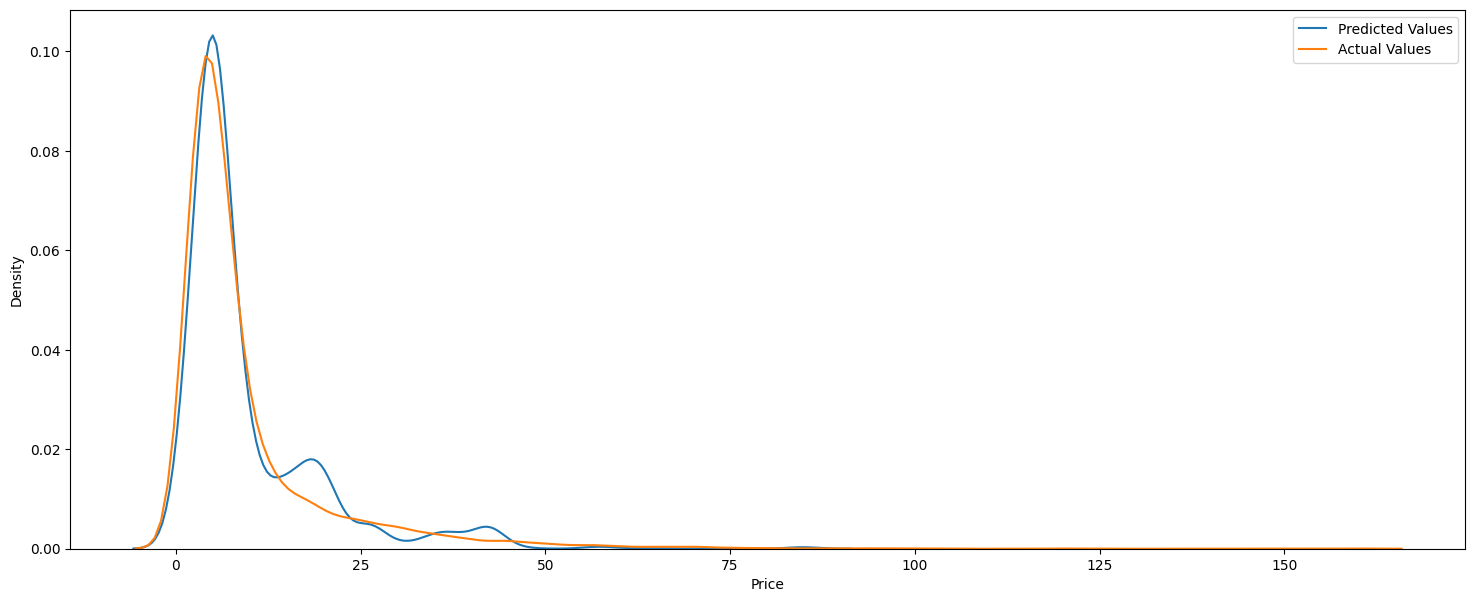

In [ ]:
plt.figure(figsize=(18, 7))
ax1 = sns.distplot(y_hat, hist=False, label='Predicted Values')
sns.distplot(y, hist=False, label='Actual Values', ax=ax1)
plt.legend()
plt.title('')
plt.savefig('Random Forest Price by Engine CC.png')
plt.show()
plt.close()
plt.show()

In [ ]:
# Performance
print("Mean Squared Error = ", mean_squared_error(y_test, y_hat, squared = True))
print("Root Mean Squared Error = ", mean_squared_error(y_test, y_hat, squared = False))
print("Mean Absolute Error = ", mean_absolute_error(y_test, y_hat))
print("R-Squared: = ", r2_score(y_test, y_hat))

Mean Squared Error =  52.43186135844851
Root Mean Squared Error =  7.240984833463505
Mean Absolute Error =  3.71961937535334
R-Squared: =  0.5825355746036323


Random Forest (Power bph | Price)

In [ ]:
X = df[["Power bph"]]
y = df["Price"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

standardScaler = StandardScaler()
standardScaler.fit(x_train)
x_train = standardScaler.transform(x_train)
x_test = standardScaler.transform(x_test)

rf = RandomForestRegressor(n_estimators = 100, random_state = 1)

rf.fit(x_train, y_train)

y_hat = rf.predict(x_test)

pd.DataFrame({"Actual": y_test, "Predicted": y_hat}).head()


,Actual,Predicted
5150,7.25,10.70
2164,4.25,4.33
1136,3.90,4.81
5641,8.41,11.01
1515,13.48,10.63


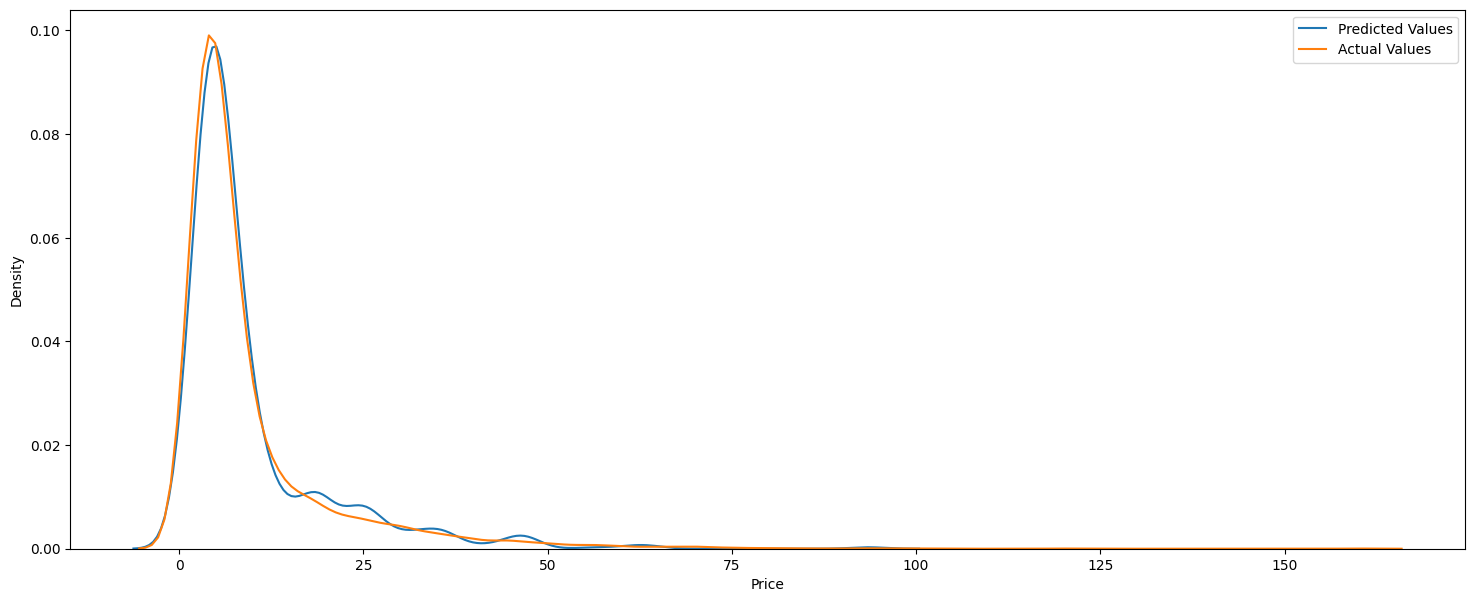

In [ ]:
plt.figure(figsize=(18, 7))
ax1 = sns.distplot(y_hat, hist=False, label='Predicted Values')
sns.distplot(y, hist=False, label='Actual Values', ax=ax1)
plt.legend()
plt.title('')
plt.savefig('Random Forest Price by Power bph.png')
plt.show()
plt.close()
plt.show()

In [ ]:
# Performance
print("Mean Squared Error = ", mean_squared_error(y_test, y_hat, squared = True))
print("Root Mean Squared Error = ", mean_squared_error(y_test, y_hat, squared = False))
print("Mean Absolute Error = ", mean_absolute_error(y_test, y_hat))
print("R-Squared: = ", r2_score(y_test, y_hat))

Mean Squared Error =  36.11952408461719
Root Mean Squared Error =  6.009952086715599
Mean Absolute Error =  2.804879087196865
R-Squared: =  0.7124150091775197


Random Forest (Seats | Price)

In [ ]:
X = df[["Seats"]]
y = df["Price"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

standardScaler = StandardScaler()
standardScaler.fit(x_train)
x_train = standardScaler.transform(x_train)
x_test = standardScaler.transform(x_test)

rf = RandomForestRegressor(n_estimators = 100, random_state = 1)

rf.fit(x_train, y_train)

y_hat = rf.predict(x_test)

pd.DataFrame({"Actual": y_test, "Predicted": y_hat}).head()



,Actual,Predicted
5150,7.25,14.59
2164,4.25,8.51
1136,3.90,8.51
5641,8.41,14.59
1515,13.48,7.56


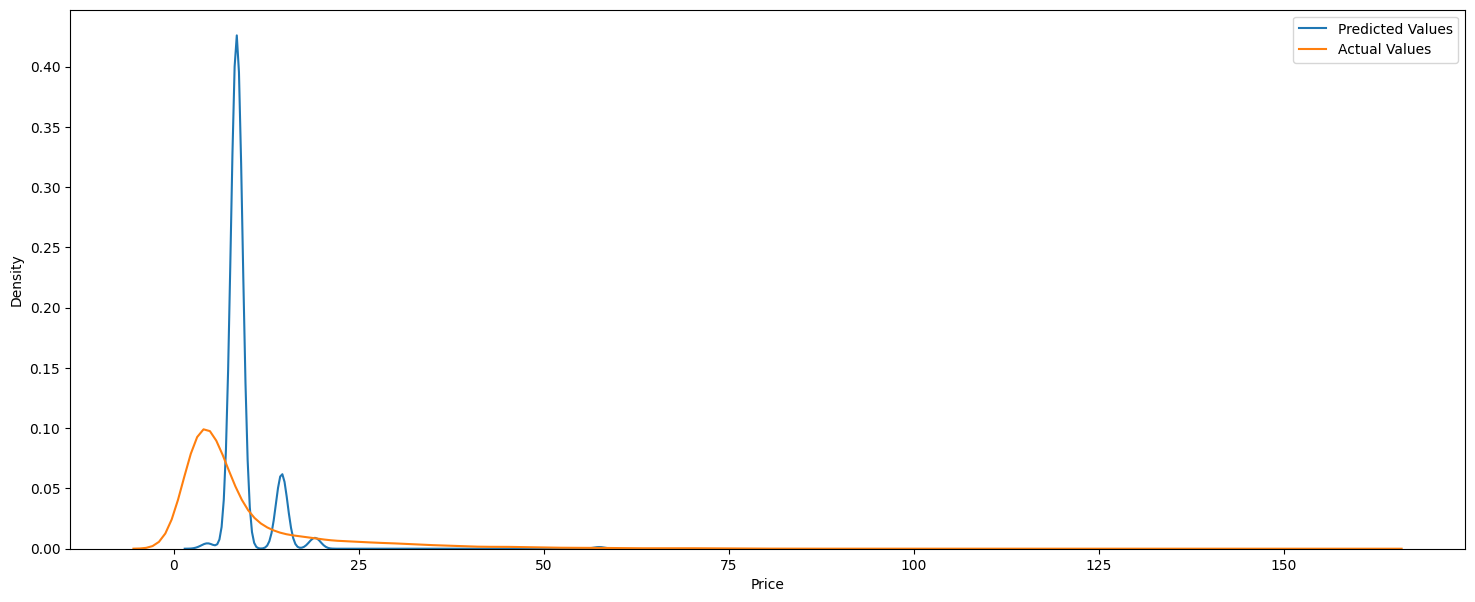

In [ ]:
plt.figure(figsize=(18, 7))
ax1 = sns.distplot(y_hat, hist=False, label='Predicted Values')
sns.distplot(y, hist=False, label='Actual Values', ax=ax1)
plt.legend()
plt.title('')
plt.savefig('Random Forest Price by Seats.png')
plt.show()
plt.close()
plt.show()

In [ ]:
# Performance
print("Mean Squared Error = ", mean_squared_error(y_test, y_hat, squared = True))
print("Root Mean Squared Error = ", mean_squared_error(y_test, y_hat, squared = False))
print("Mean Absolute Error = ", mean_absolute_error(y_test, y_hat))
print("R-Squared: = ", r2_score(y_test, y_hat))

Mean Squared Error =  112.14260363846006
Root Mean Squared Error =  10.589740489665461
Mean Absolute Error =  6.706888631515043
R-Squared: =  0.10711642925797449


Multiple Random Forest

In [ ]:
X = df[["Year", "Engine CC", "Power bph", "Seats"]]
y = df["Price"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

standardScaler = StandardScaler()
standardScaler.fit(x_train)
x_train = standardScaler.transform(x_train)
x_test = standardScaler.transform(x_test)

rf = RandomForestRegressor(n_estimators = 100, random_state = 1)

rf.fit(x_train, y_train)

y_hat = rf.predict(x_test)
print(y_hat)

pd.DataFrame({"Actual": y_test, "Predicted": y_hat}).head()

[ 8.3965225   2.49291786  4.38084108 ...  6.15588917 28.55386302
  4.9790652 ]


,Actual,Predicted
5150,7.25,8.40
2164,4.25,2.49
1136,3.90,4.38
5641,8.41,9.26
1515,13.48,14.24


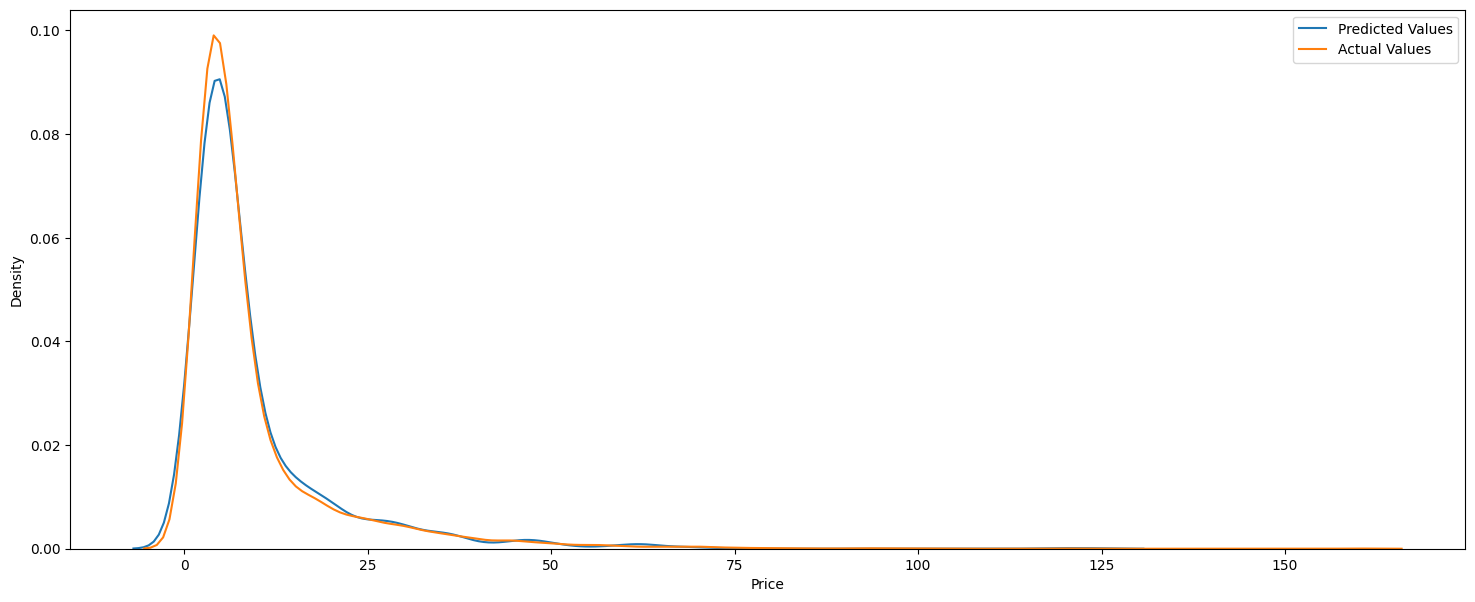

In [ ]:
plt.figure(figsize=(18, 7))
ax1 = sns.distplot(y_hat, hist=False, label='Predicted Values')
sns.distplot(y, hist=False, label='Actual Values', ax=ax1)
plt.legend()
plt.title('')
plt.savefig('Multiple Random Forest.png')
plt.show()
plt.close()
plt.show()

In [ ]:
# Performance
print("Mean Squared Error = ", mean_squared_error(y_test, y_hat, squared = True))
print("Root Mean Squared Error = ", mean_squared_error(y_test, y_hat, squared = False))
print("Mean Absolute Error = ", mean_absolute_error(y_test, y_hat))
print("R-Squared: = ", r2_score(y_test, y_hat))

Mean Squared Error =  23.041052751313625
Root Mean Squared Error =  4.800109660342525
Mean Absolute Error =  1.8776449500560701
R-Squared: =  0.8165462831541336
